In [1]:
from scipy import signal
import numpy as np
import pandas as pd

import bisect
import importlib

# TODO

- Share notebooks
- CpG vs non-CpG
- Pi from each genome
- Compute TS and TV acxross hostpios

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
# My local version of scipy cwt peak finding
from cwt import find_peaks_cwt

[72, 115, 172]


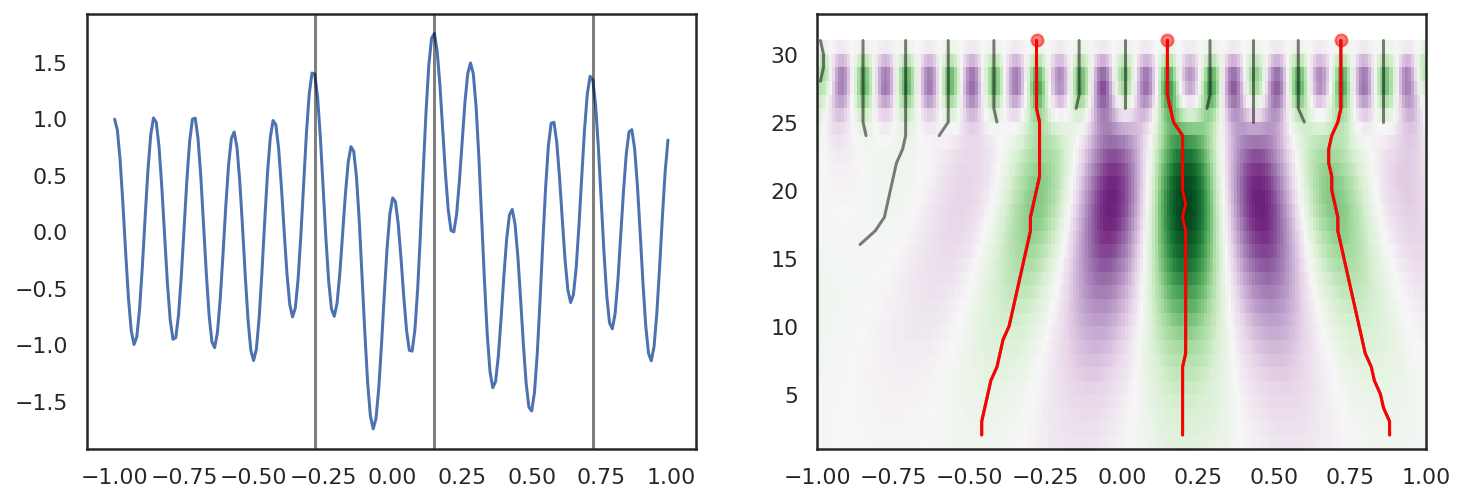

In [4]:
np.random.seed(7)

t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.2, fc=2) + np.random.randint(0, 1, size=200)

max_width = 31
widths = np.arange(1, max_width)
cwtmatr = signal.cwt(sig, signal.ricker, widths)

#peakind = signal.find_peaks_cwt(sig, 
all_lines, filtered_lines, peakind = find_peaks_cwt(sig, 
                                widths,
                                wavelet=signal.ricker, 
                                max_distances=widths,#widths/4,
                                gap_thresh=2,
                                min_length=len(widths)/1.3, #len(widths)/4,
                                min_snr=1,
                                noise_perc=0 )

print(peakind)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(t, sig)
ax2.imshow(cwtmatr, extent=[-1, 1, 1, max_width], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
for i in peakind:
    ax1.axvline(t[i], color='black', alpha=0.5)
    ax2.scatter(t[i], max_width, color='red', alpha=0.5)
    
for line in all_lines:
    row, col = line
    y = [max_width-i for i in row]
    x = [t[i] for i in col]
    ax2.plot(x, y, color='black', alpha=0.5)
for line in filtered_lines:
    row, col = line
    y = [max_width-i for i in row]
    x = [t[i] for i in col]
    ax2.plot(x, y, color='red')

In [5]:
xs = np.arange(0, np.pi, 0.05)
data = np.sin(xs)
peakind = signal.find_peaks_cwt(data, np.arange(1,10))
peakind, xs[peakind], data[peakind]


(array([32]), array([1.6]), array([0.9995736]))

Hi Kasper,

I have updated the skew files by adding skews in pairs of substitution rates (according to how they pair up in the previous transition and transversion plots).
The figures are a bit chaotic, but vertical lines now mark hotspot centers.
Colours of lines are in pairs (greens are ratios of transitions, while reds and oranges are ratios of transversions). On many chromosomes you can see how they are going in opposite direction to each other, red up when pink down and so on.

Examples:
skew_GC = (nG+nC)/(nG+nC)
skew_TCAG = (nT2C-nA2G)/(nT2C+nA2G)

I will work on producing the files for composition around each hotspot.


I updated the files.

The reported skews are now substitutions to and from a certain nucleotide.
While skew_GC = (nG-nC)/(nG+nC) represent composition, skew_XGXC is the substitution-based equivalent (nX2G-nX2C)/(nX2G+nX2C), where X is any nucleotide. If the substitution pattern is consistent with the composition, these should follow each other (and do to a large degree, more so for GC than AT).

I also calculated skews for increase and decrease of each nucleotide.
skew_XGGX = (nX2G-nG2X)/(nX2G+nG2X) is the difference in G-increasing vs. G-decreasing substitutions.

I hope you can understand what I have done :)

## Load composition and substitution data

In [29]:
# chromosomes = ['1', '1A', '2', '3', '4', '4A', '5', '6', '7', 
#                '8', '9', '10', '11', '12', '13', '14', '15']
# tmpl = '/Users/kmt/Dropbox/Shared/jonas_kasper/skew/chr{}.skew.txt'
# lst = list()
# for chrom in chromosomes:
#     df = pd.read_csv(tmpl.format(chrom), sep=' ')
#     df['chrom'] = chrom
#     lst.append(df)
# skew_data = pd.concat(lst)
# skew_data['end'] = skew_data.start + 1000
# skew_data['s'] = (skew_data.skew_GC - skew_data.skew_GC.shift()) + (skew_data.skew_TA - skew_data.skew_TA).shift()
# # skew_data['s'] = ((skew_data.skew_GC + skew_data.skew_TA) - (skew_data.skew_GC + skew_data.skew_TA).shift())
# skew_data['s_diff'] = skew_data.s - skew_data.s.shift()
# skew_data = skew_data.drop(skew_data.index[[0,1]])
# skew_data.head()

chromosomes = ['1', '1A', '2', '3', '4', '4A', '5', '6', '7', 
               '8', '9', '10', '11', '12', '13', '14', '15']
tmpl = '/project/Birds/faststorage/data/skew/chr{}.skew.txt'
lst = list()
for chrom in chromosomes:
    df = pd.read_csv(tmpl.format(chrom), sep=' ')
    df['chrom'] = chrom
    lst.append(df)
skew_data = pd.concat(lst)
skew_data['end'] = skew_data.start + 1000
skew_data.head()

# composition skews:
skew_data['skew_GC'] = (skew_data.nG-skew_data.nC)/(skew_data.nG+skew_data.nC)
skew_data['skew_TA'] = (skew_data.nT-skew_data.nA)/(skew_data.nT+skew_data.nA)
skew_data['s'] = skew_data.skew_GC + skew_data.skew_TA #(skew_data.skew_GC - skew_data.skew_GC.shift()) + (skew_data.skew_TA - skew_data.skew_TA).shift()
skew_data['s_diff'] = skew_data.s - skew_data.s.shift()
skew_data['s_cum'] = skew_data.s.cumsum()

# equilibrium composition skews:
GCflux = (skew_data.nA2C + skew_data.nT2C + skew_data.nA2G + skew_data.nT2G) / \
                (skew_data.nC2A + skew_data.nC2T + skew_data.nG2A + skew_data.nT2C)
skew_data['GCstar'] = GCflux/(1 + GCflux)

# substitution skews:
skew_TCAG = (skew_data.nT2C-skew_data.nA2G)/(skew_data.nT2C+skew_data.nA2G)

# equilibrium substution skews:



skew_data.reset_index(inplace=True)
skew_data.head()

index  start   nA   nC   nG   nT  nA2C  nA2G  nA2T  nC2A  ...  nT2C  nT2G  \
0      0      0  336  166  173  252     2     5     1     4  ...    12     6   
1      1   1000  235  164  183  217     3     7     4     2  ...     7     7   
2      2   2000   81   71   77   77     1     3     0     2  ...     5     1   
3      3   3000  193  204  262  260     1     8     2     3  ...    14     7   
4      4   4000  161  188  164  167     4     7     4     2  ...     2     5   

   chrom   end   skew_GC   skew_TA         s    s_diff     s_cum    GCstar  
0      1  1000  0.020649 -0.142857 -0.122208       NaN -0.122208  0.480769  
1      1  2000  0.054755 -0.039823  0.014932  0.137140 -0.107276  0.648649  
2      1  3000  0.040541 -0.025316  0.015224  0.000292 -0.092052  0.400000  
3      1  4000  0.124464  0.147903  0.272366  0.257142  0.180314  0.461538  
4      1  5000 -0.068182  0.018293 -0.049889 -0.322256  0.130425  0.580645  

[5 rows x 26 columns]

## Load hotspot annotation

In [21]:
hotspot_overlaps = pd.read_csv('/home/kmt/Birds/faststorage/people/kmt/hotspot_overlaps.txt', sep=' ')
hotspot_overlaps['pos'] = (hotspot_overlaps.start + (hotspot_overlaps.stop - hotspot_overlaps.start) / 2).astype(int)
hotspot_overlaps['chrom'] = hotspot_overlaps['chr'].str.replace('chr', '')
hotspot_overlaps.rename(columns={'stop': 'end'}, inplace=True)
# hotspot_overlaps.set_index(['chrom', 'pos'], inplace=True)
hotspot_overlaps.head()

chr     start       end  exons  introns  promoters_minus  promoters_plus  \
0  chr1   6892116   6896116      0        0                0               0   
1  chr1   8803005   8807005      0        0                0               0   
2  chr1   9684030   9690030      0        1                0               0   
3  chr1  10395061  10399061      0        0                0               0   
4  chr1  10500751  10506751      1        1                0               1   

   intergenic       pos chrom  
0           1   6894116     1  
1           1   8805005     1  
2           0   9687030     1  
3           1  10397061     1  
4           1  10503751     1

## Predict replication origins as s-jumps

In [44]:
def s_jumps(df, col, plot=False, vlines=[]):
    max_width = 300
    min_width = 5
    step = 1
    
    data = np.array(df[col])
    s = np.array(df.s)
    t = np.array(df.start)

    widths = np.arange(min_width, max_width, step)

    all_lines, filtered_lines, peakind = find_peaks_cwt(data, 
                                    widths,
                                    wavelet=signal.ricker, 
                                    max_distances=widths/1,
                                    gap_thresh=2,
                                    min_length=len(widths)/1.2, #len(widths)/4,
                                    min_snr=0.5, # 1
                                    noise_perc=0 )
#     print(all_lines)

    if plot:
        cwtmatr = signal.cwt(data, signal.ricker, widths)

        fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(30, 15), sharex=True)

        ax0.plot(t, s, linewidth=0.2)

        smooth = lowess(s, t,is_sorted=True, frac=0.005, it=0)
        ax0.plot(smooth[:,0], smooth[:,1])

        ax1.plot(t, data, linewidth=0.5)
        ax2.imshow(cwtmatr, extent=[t.min(), t.max(), min_width, max_width], cmap='PRGn', aspect='auto',
                   vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        for i in peakind:
            ax0.axvline(t[i], color='black', alpha=0.5, linestyle='dashed')
            ax1.axvline(t[i], color='black', alpha=0.5)
            ax2.scatter(t[i], max_width, color='red', alpha=0.5)

        for x in vlines:
            ax0.axvline(x, color='orange', alpha=0.5)
            
        for line in all_lines:
            row, col = line
            y = [max_width-i*step for i in row]
            x = [t[i] for i in col]
            ax2.plot(x, y, color='black', alpha=0.5)
        for line in filtered_lines:
            row, col = line
            y = [max_width-i*step for i in row]
            x = [t[i] for i in col]
            ax2.plot(x, y, color='red')

    # add 1000 (window size) to make it the end of the window:
    return np.array([t[i]+1000 for i in peakind])

# The problem is that there are NaNs in the data...

In [23]:
grouped = skew_data.groupby('chrom')

## Plot selected chromosomes:

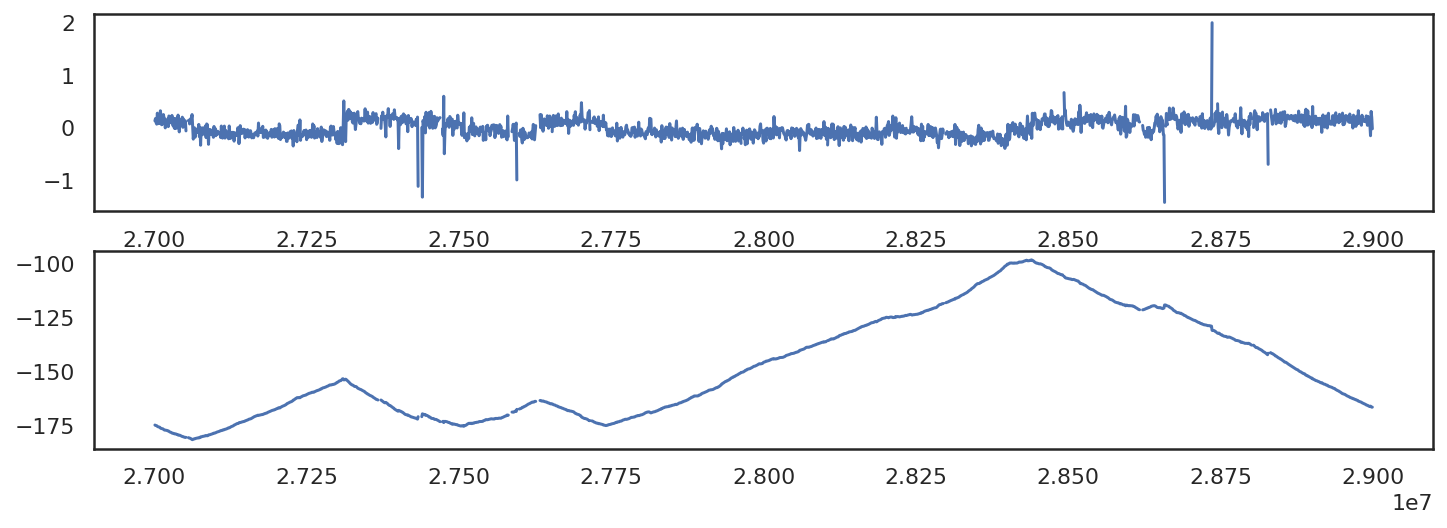

In [37]:
df = grouped.get_group('7')
df = df.loc[(df.start > 2.7e7) & (df.start < 2.9e7)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
ax1.plot(df.start, df.s)
ax2.plot(df.start, df.s_cum) ;

# It seems the big s peaks often follow missing data...

In [25]:
np.random.seed(7)

gr = grouped.get_group('15')
gr = gr.loc[~gr.s_diff.isnull()]
t = gr.start.values
sig  = gr.s_diff.values

In [26]:
t

array([    2000,     3000,     4000, ..., 14400000, 14401000, 14408000],
      dtype=int64)

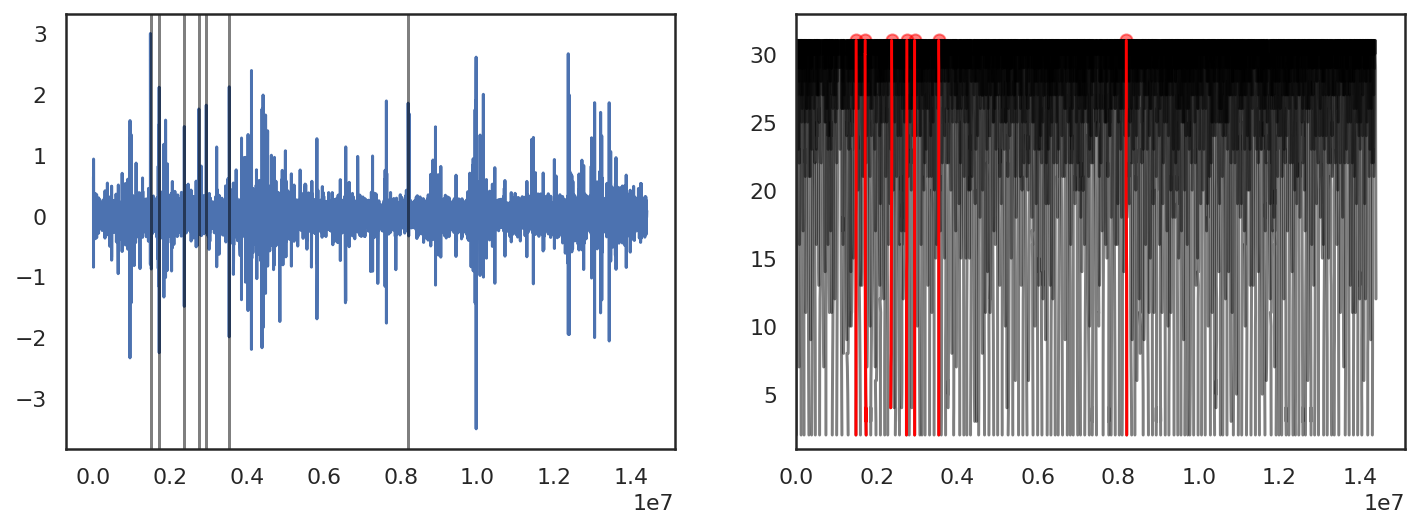

In [14]:
max_width = 31
widths = np.arange(1, max_width)
cwtmatr = signal.cwt(sig, signal.ricker, widths)

#peakind = signal.find_peaks_cwt(sig, 
all_lines, filtered_lines, peakind = find_peaks_cwt(sig, 
                                widths,
                                wavelet=signal.ricker, 
                                max_distances=widths,#widths/4,
                                gap_thresh=2,
                                min_length=len(widths)/1.3, #len(widths)/4,
                                min_snr=1,
                                noise_perc=0 )

#print(peakind)
# print(cwtmatr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(t, sig)
ax2.imshow(cwtmatr, cmap='PRGn', aspect='auto', extent=[-1, 1, 1, max_width],
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
for i in peakind:
    ax1.axvline(t[i], color='black', alpha=0.5)
    ax2.scatter(t[i], max_width, color='red', alpha=0.5)
    
for line in all_lines:
    row, col = line
    y = [max_width-i for i in row]
    x = [t[i] for i in col]
    ax2.plot(x, y, color='black', alpha=0.5)
for line in filtered_lines:
    row, col = line
    y = [max_width-i for i in row]
    x = [t[i] for i in col]
    ax2.plot(x, y, color='red')

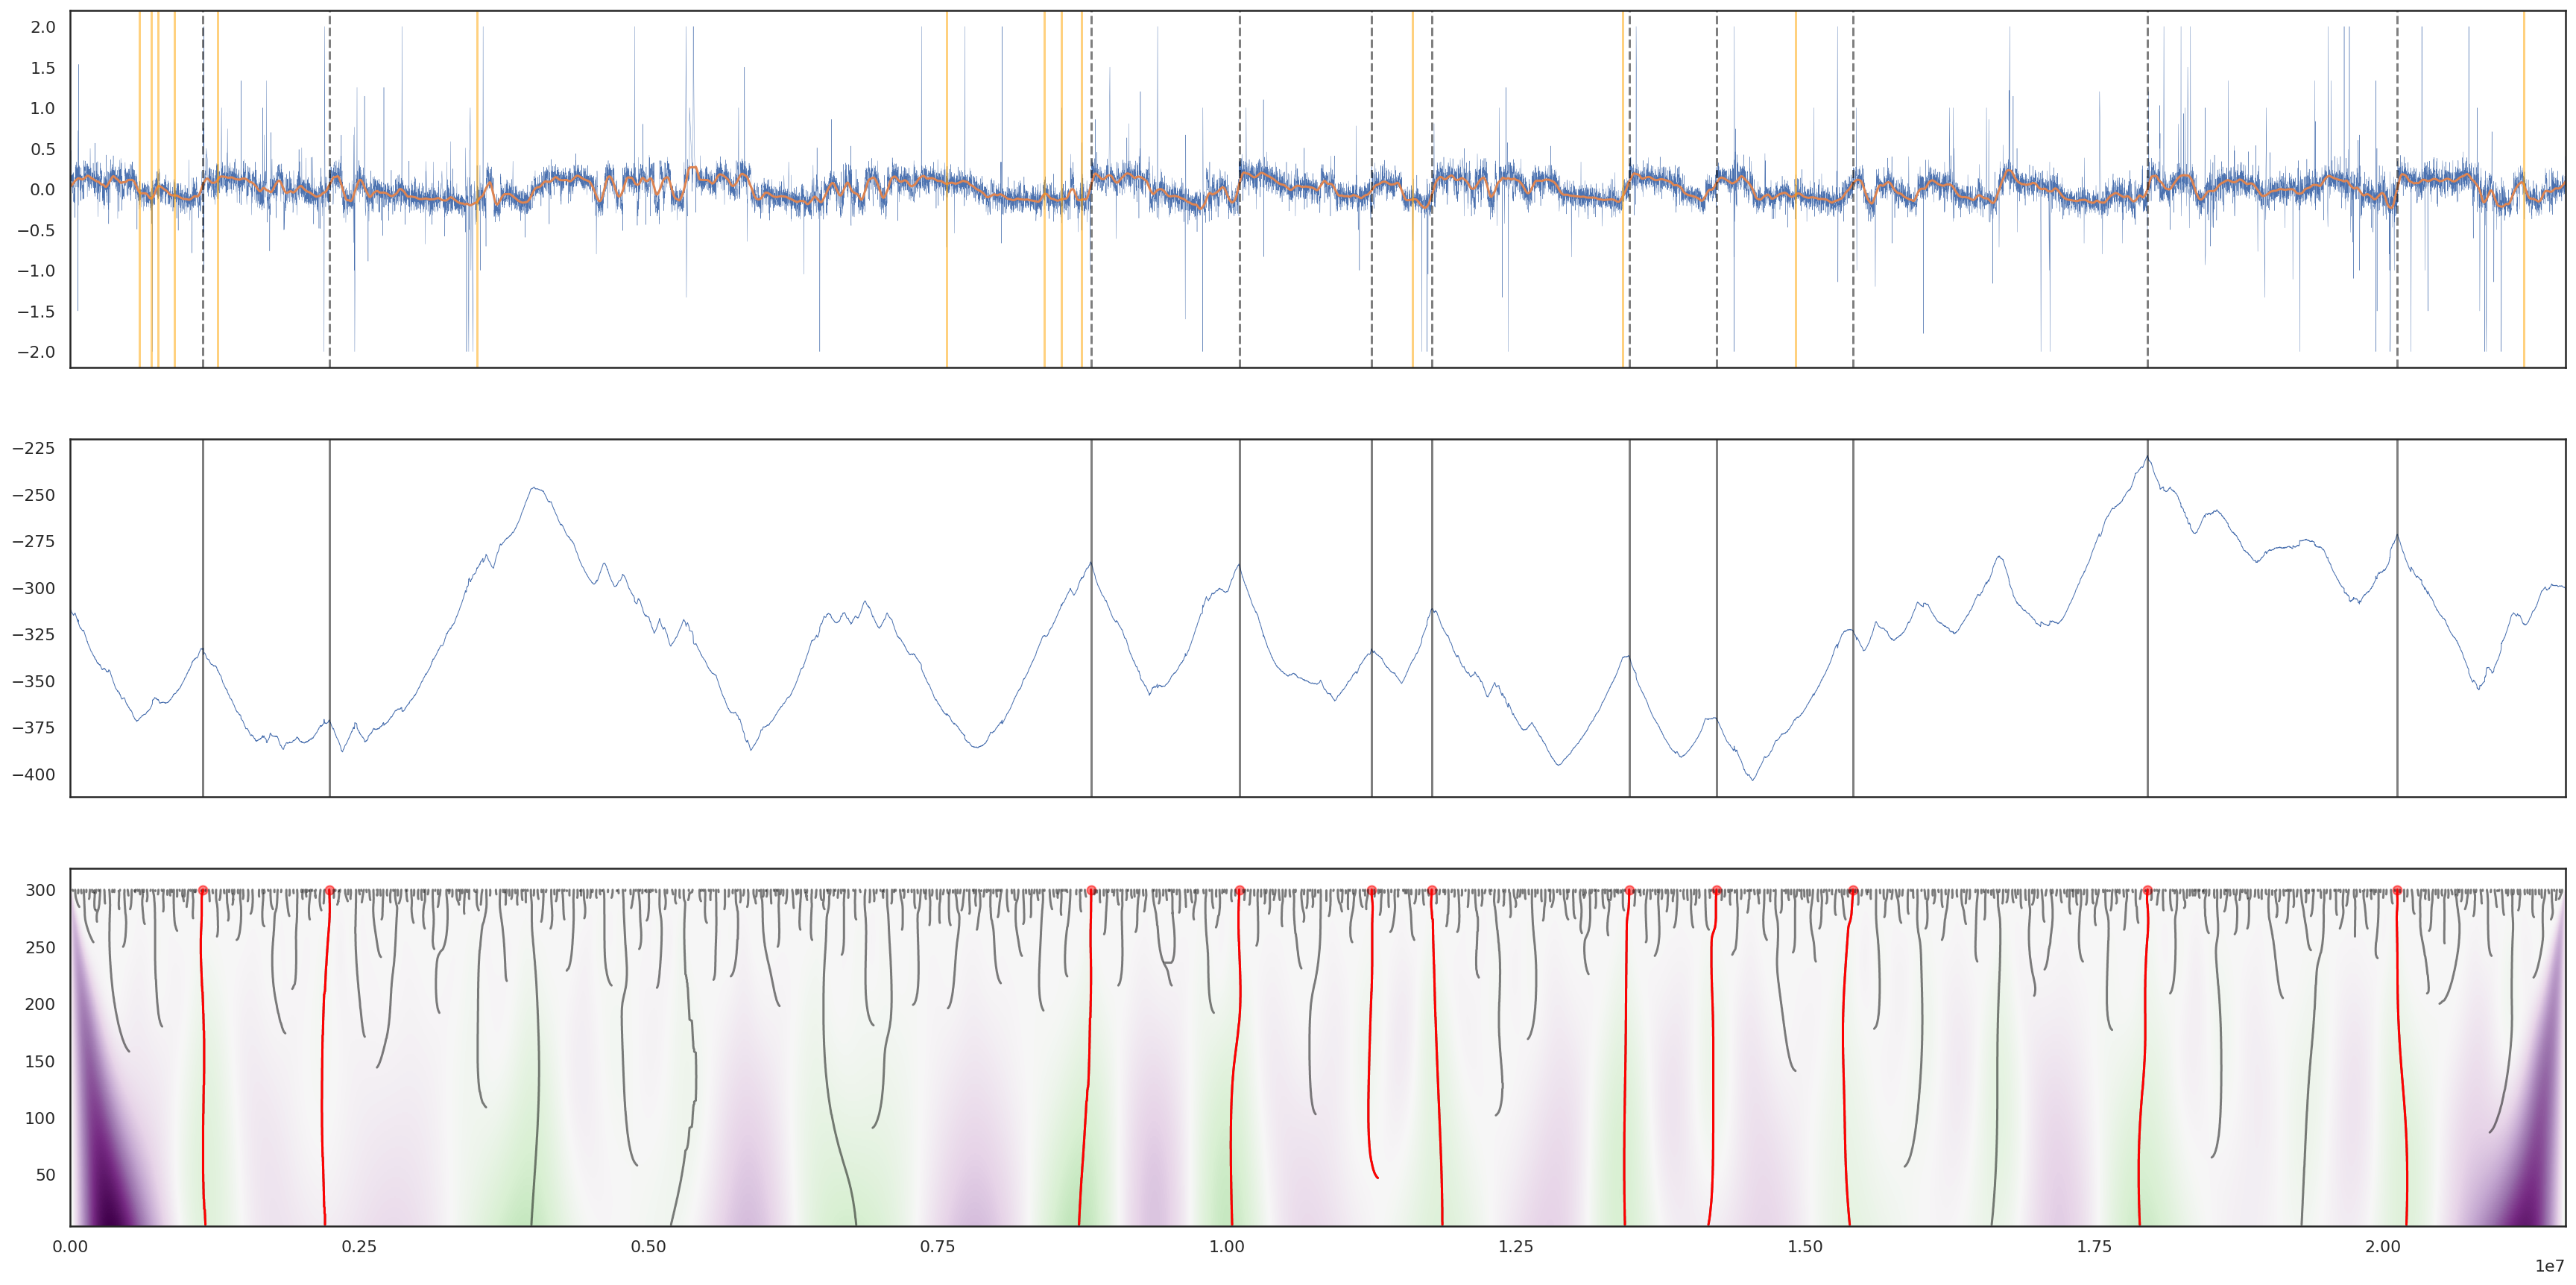

In [46]:
chrom='12'
origins = s_jumps(grouped.get_group(chrom).loc[lambda df: ~df['s_cum'].isnull()],
                  's_cum', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

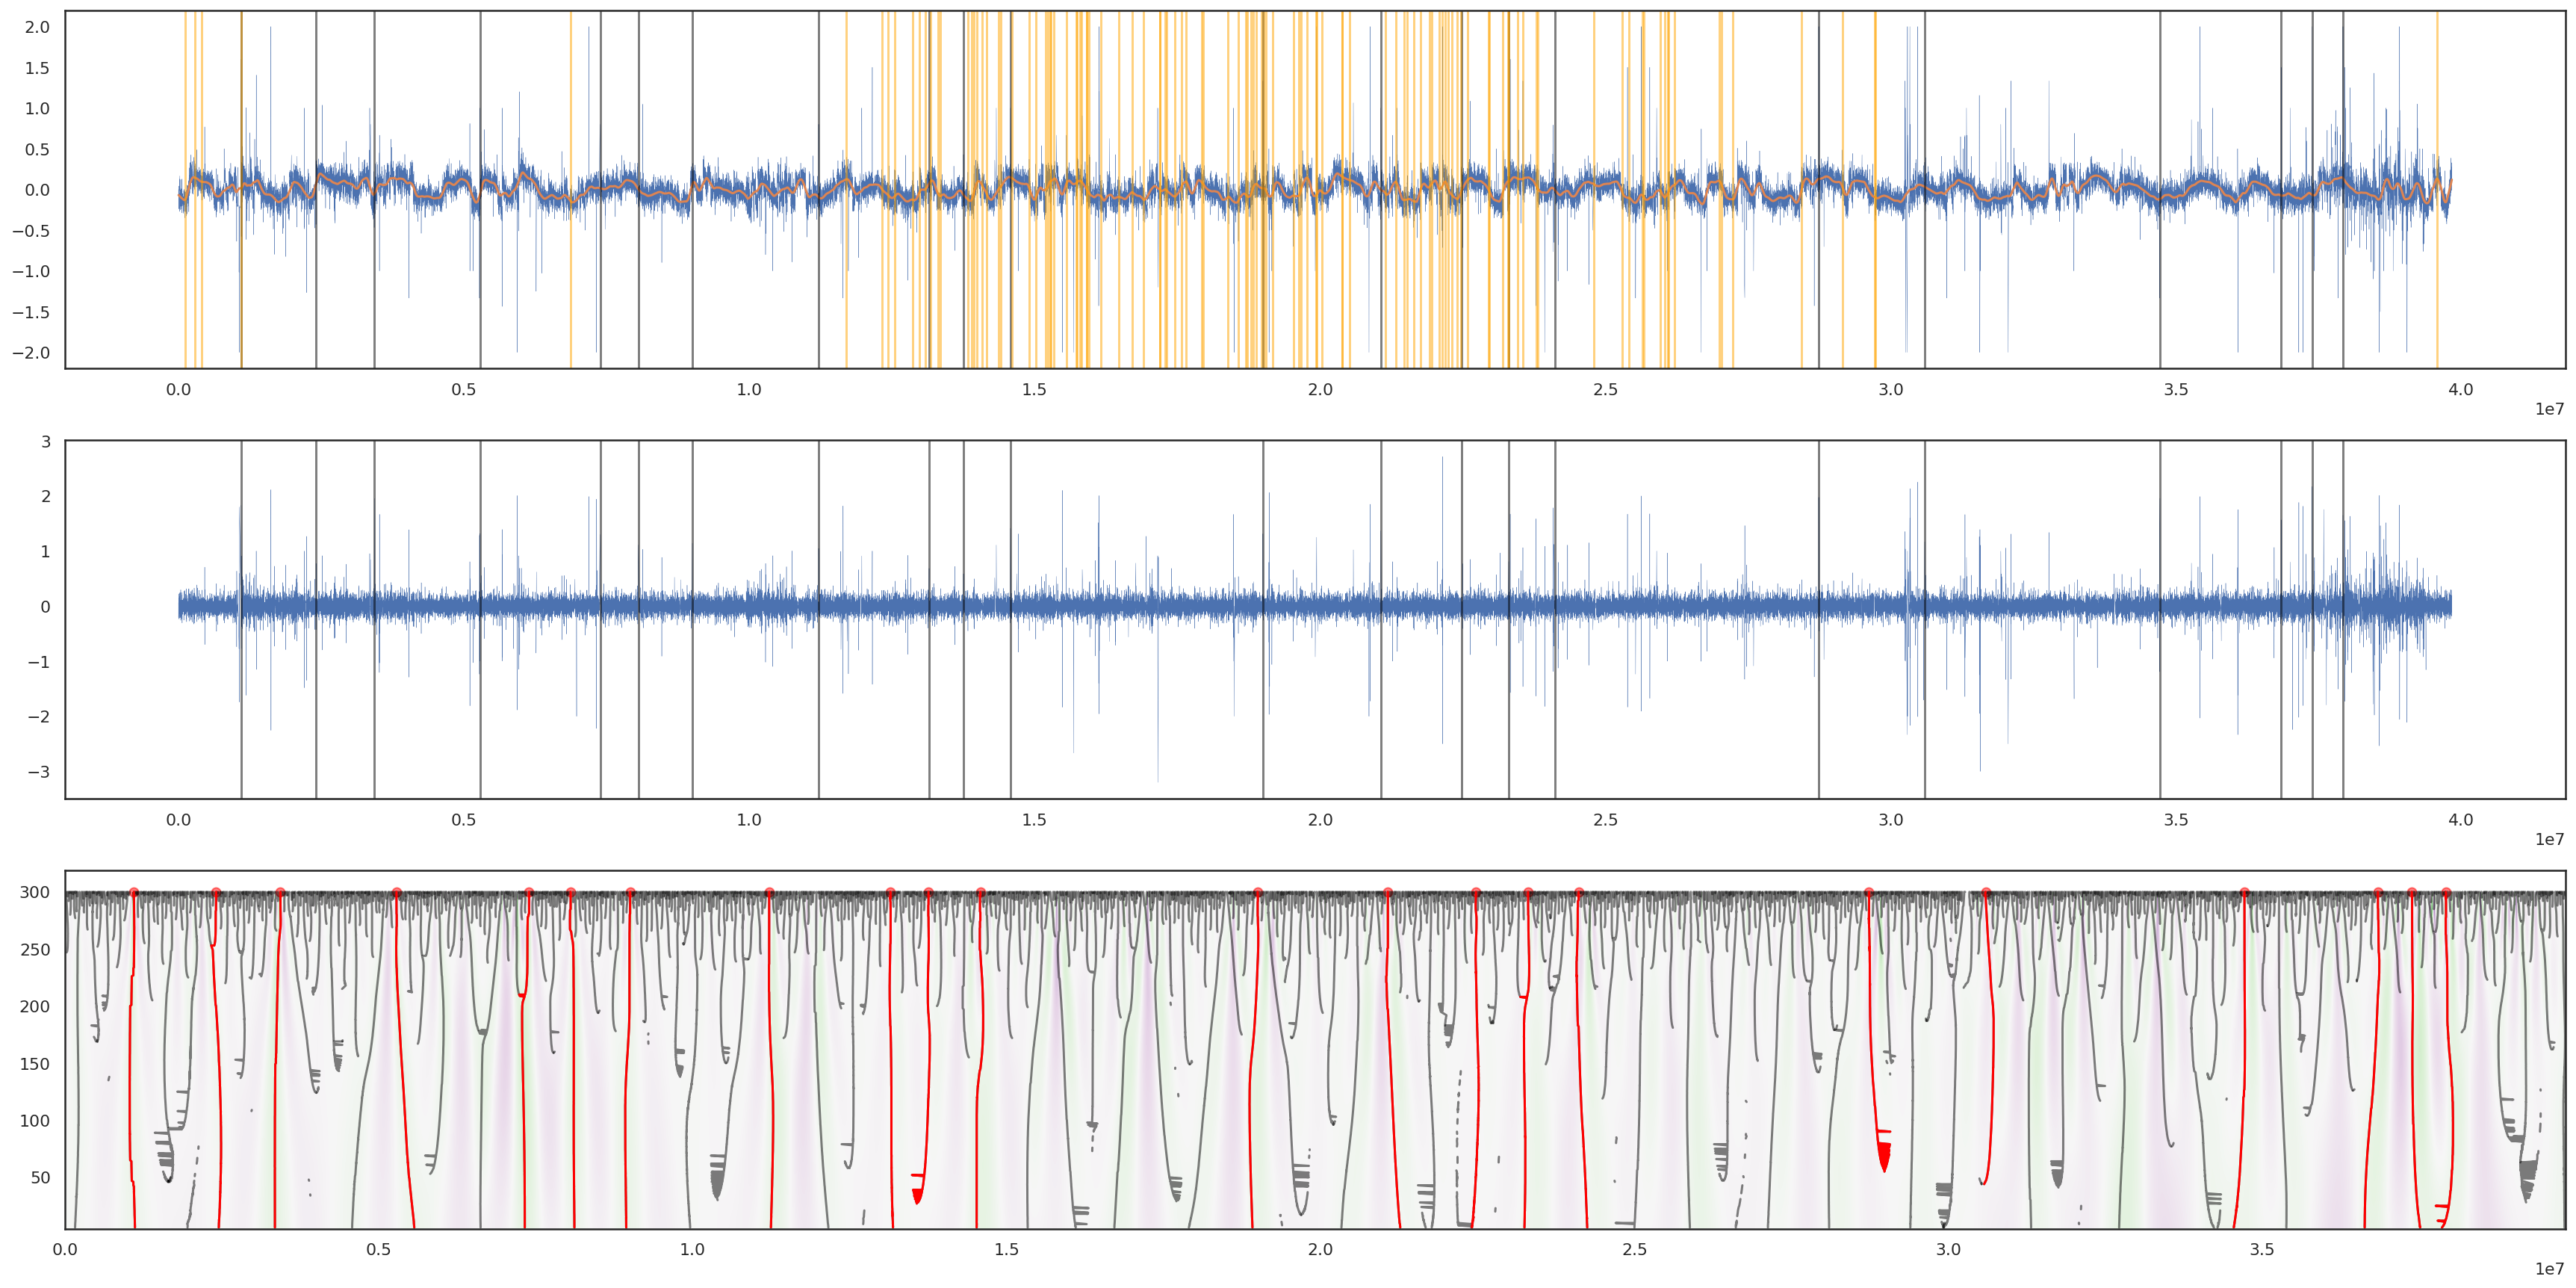

In [81]:
chrom='7'
origins = s_jumps(grouped.get_group(chrom).loc[lambda df: ~df.s_diff.isnull()],
                  's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

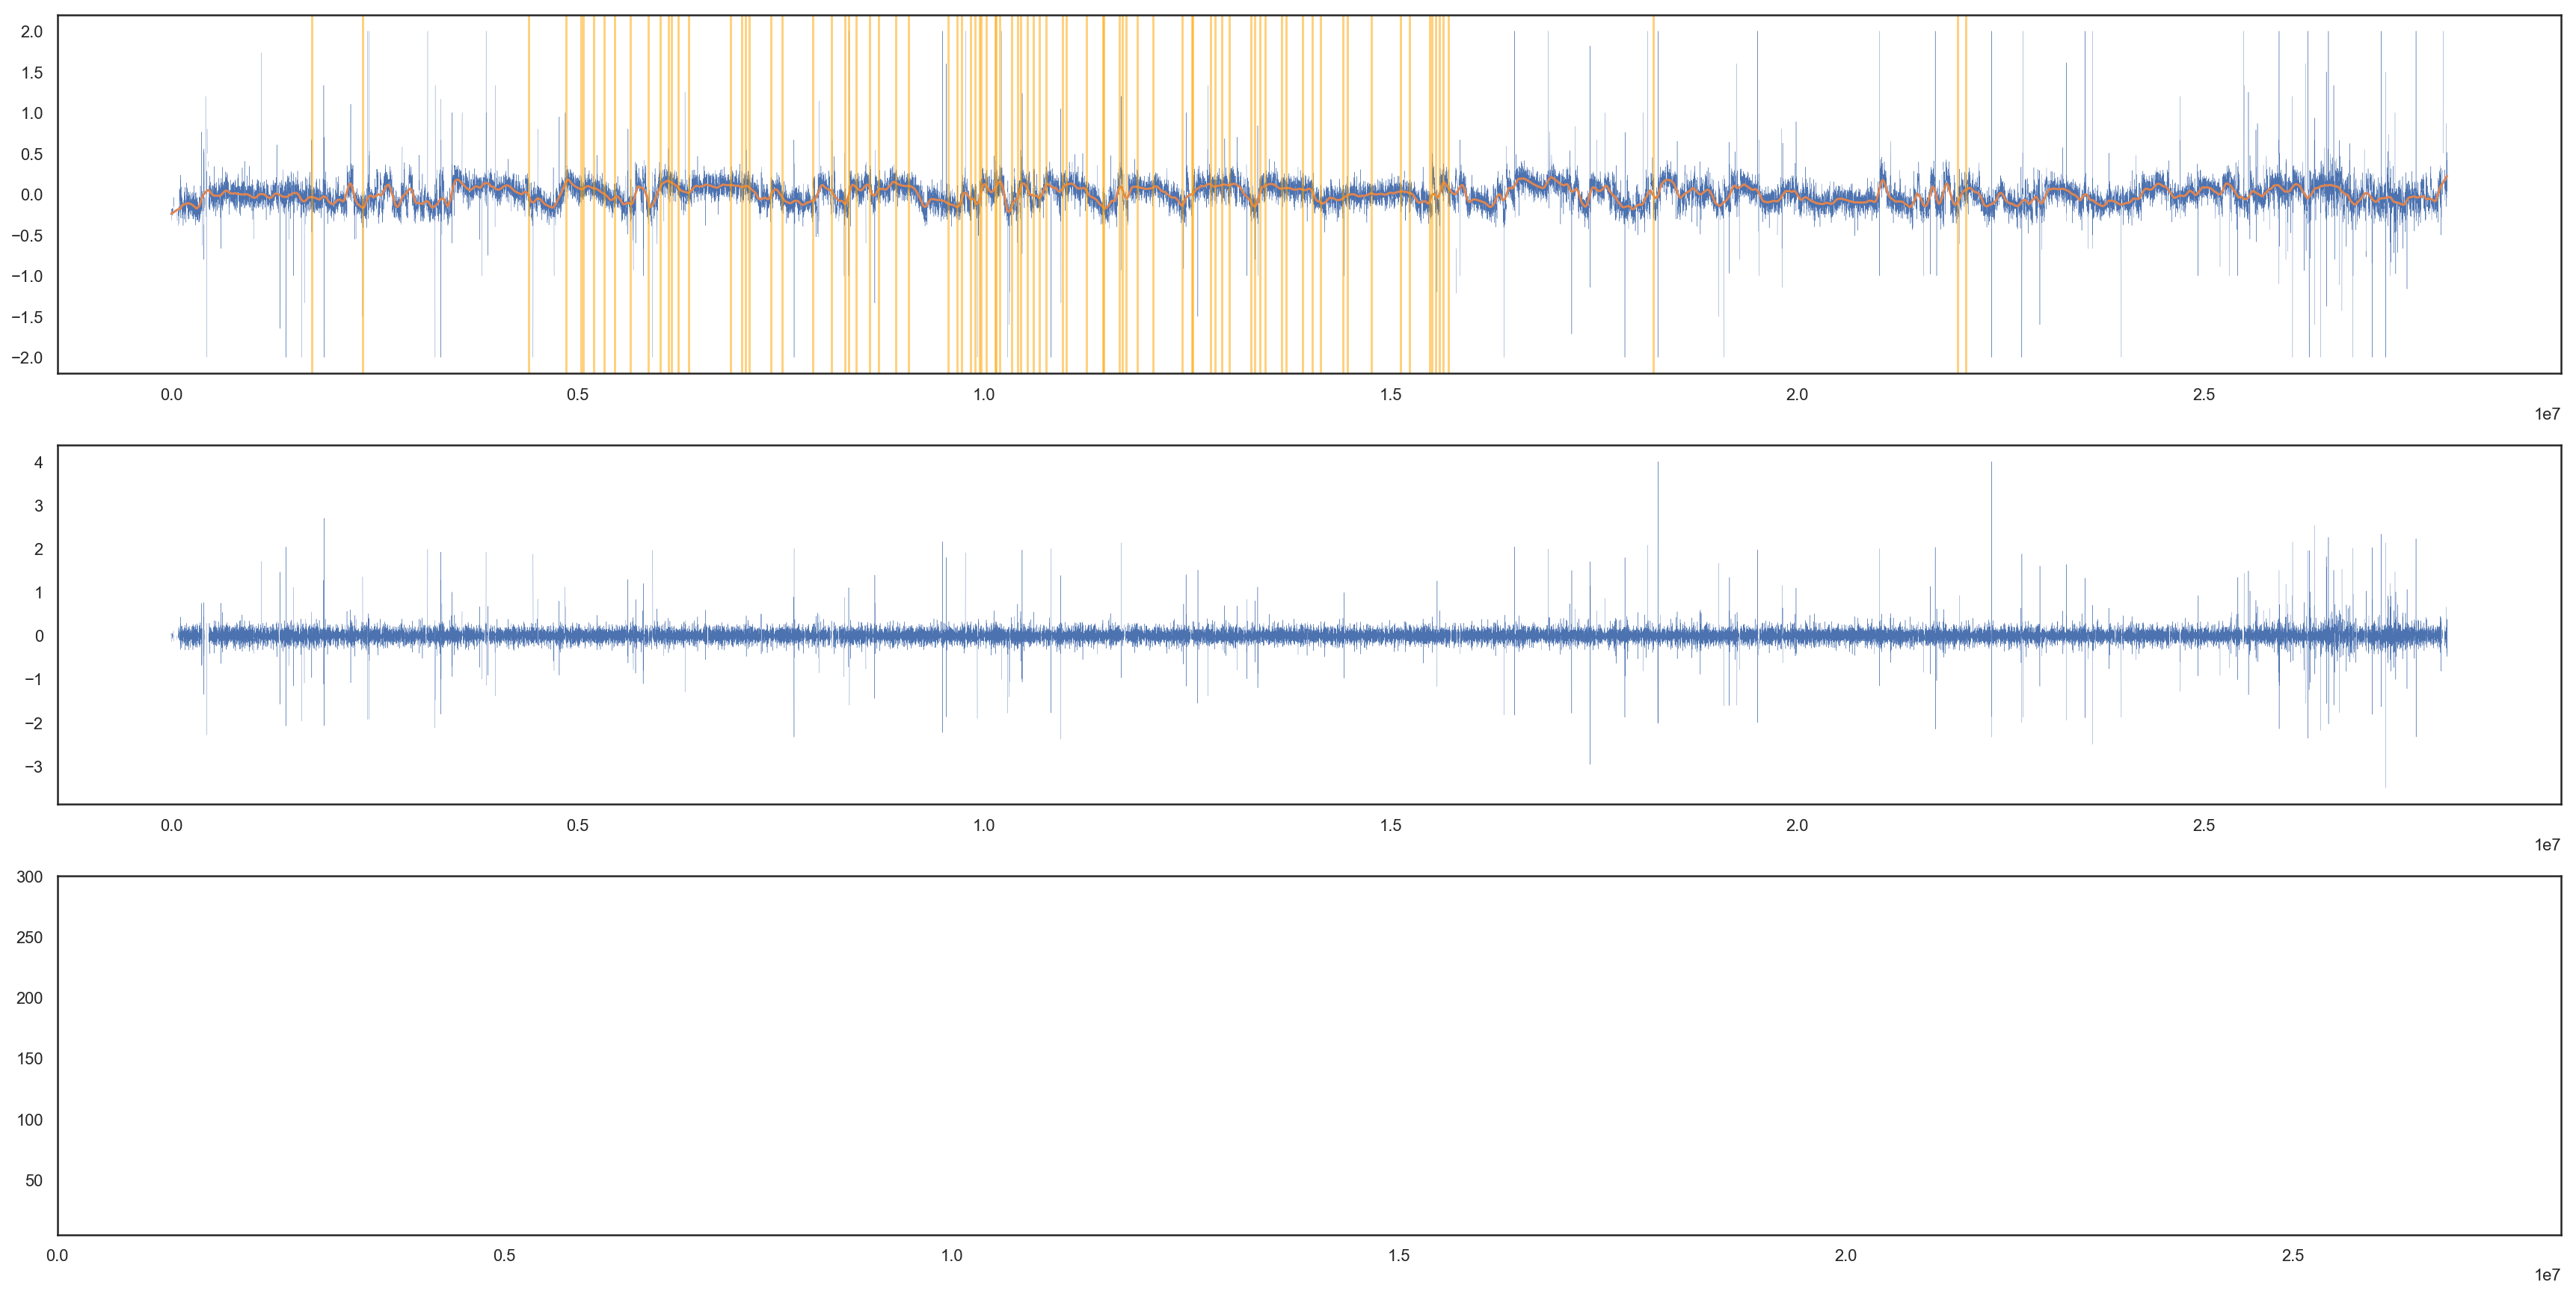

In [14]:
chrom='8'
origins = s_jumps(grouped.get_group(chrom), 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

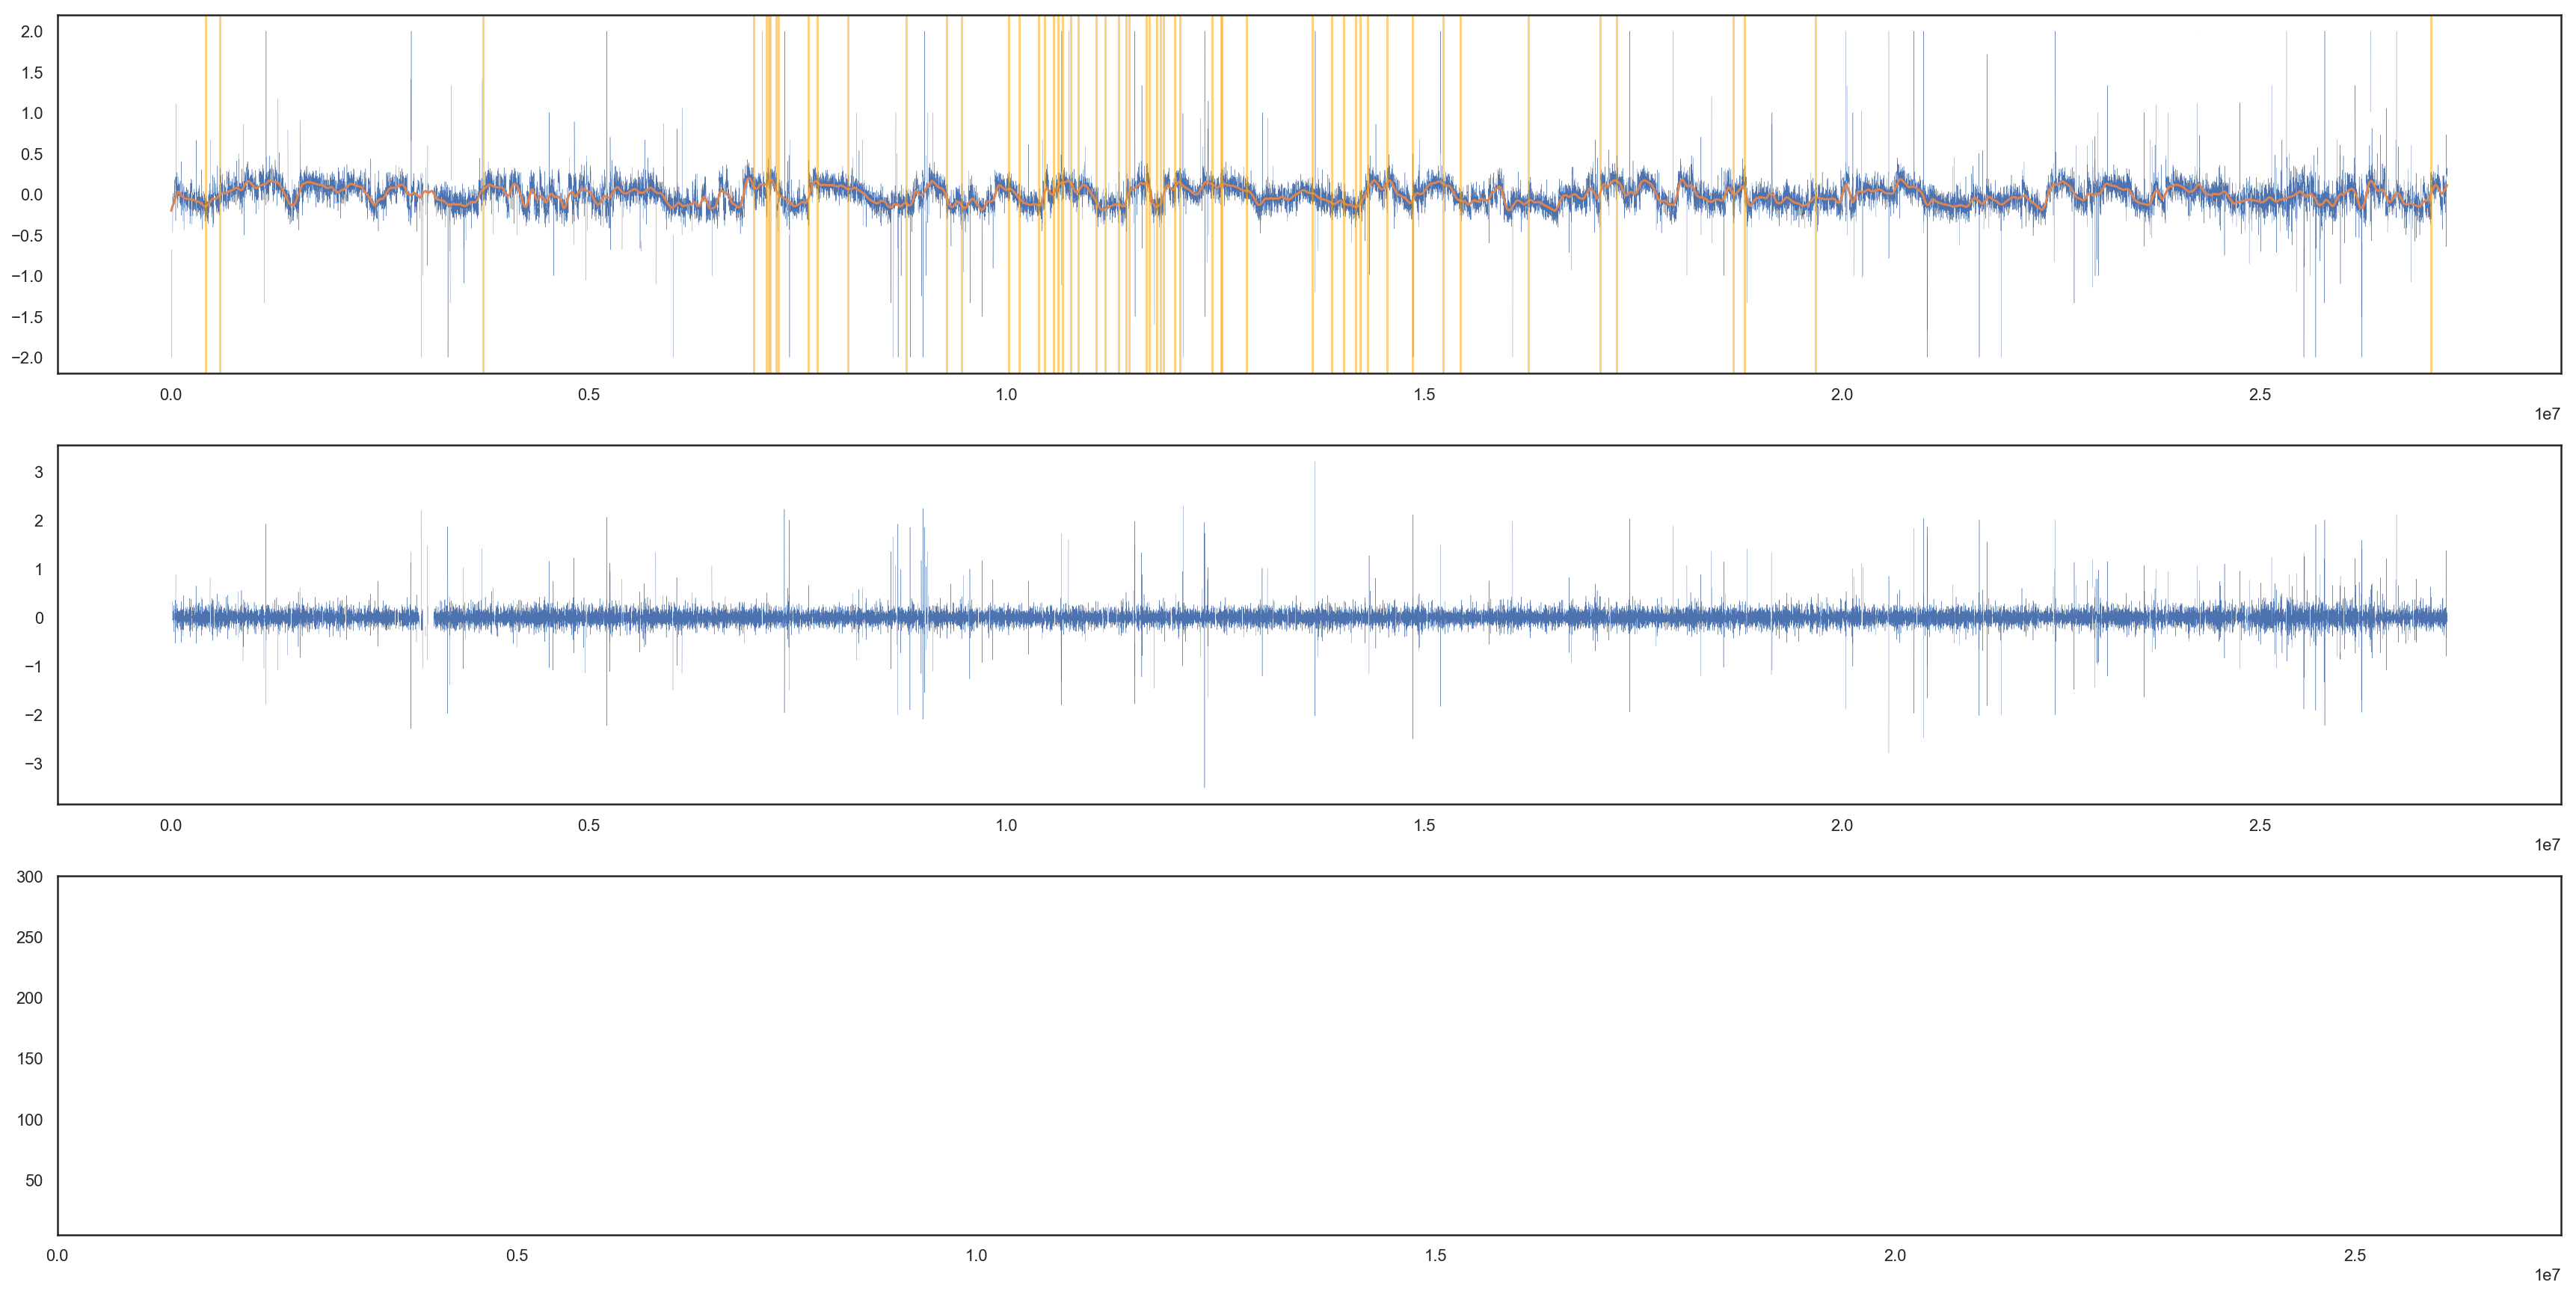

In [15]:
chrom='9'
origins = s_jumps(grouped.get_group(chrom), 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

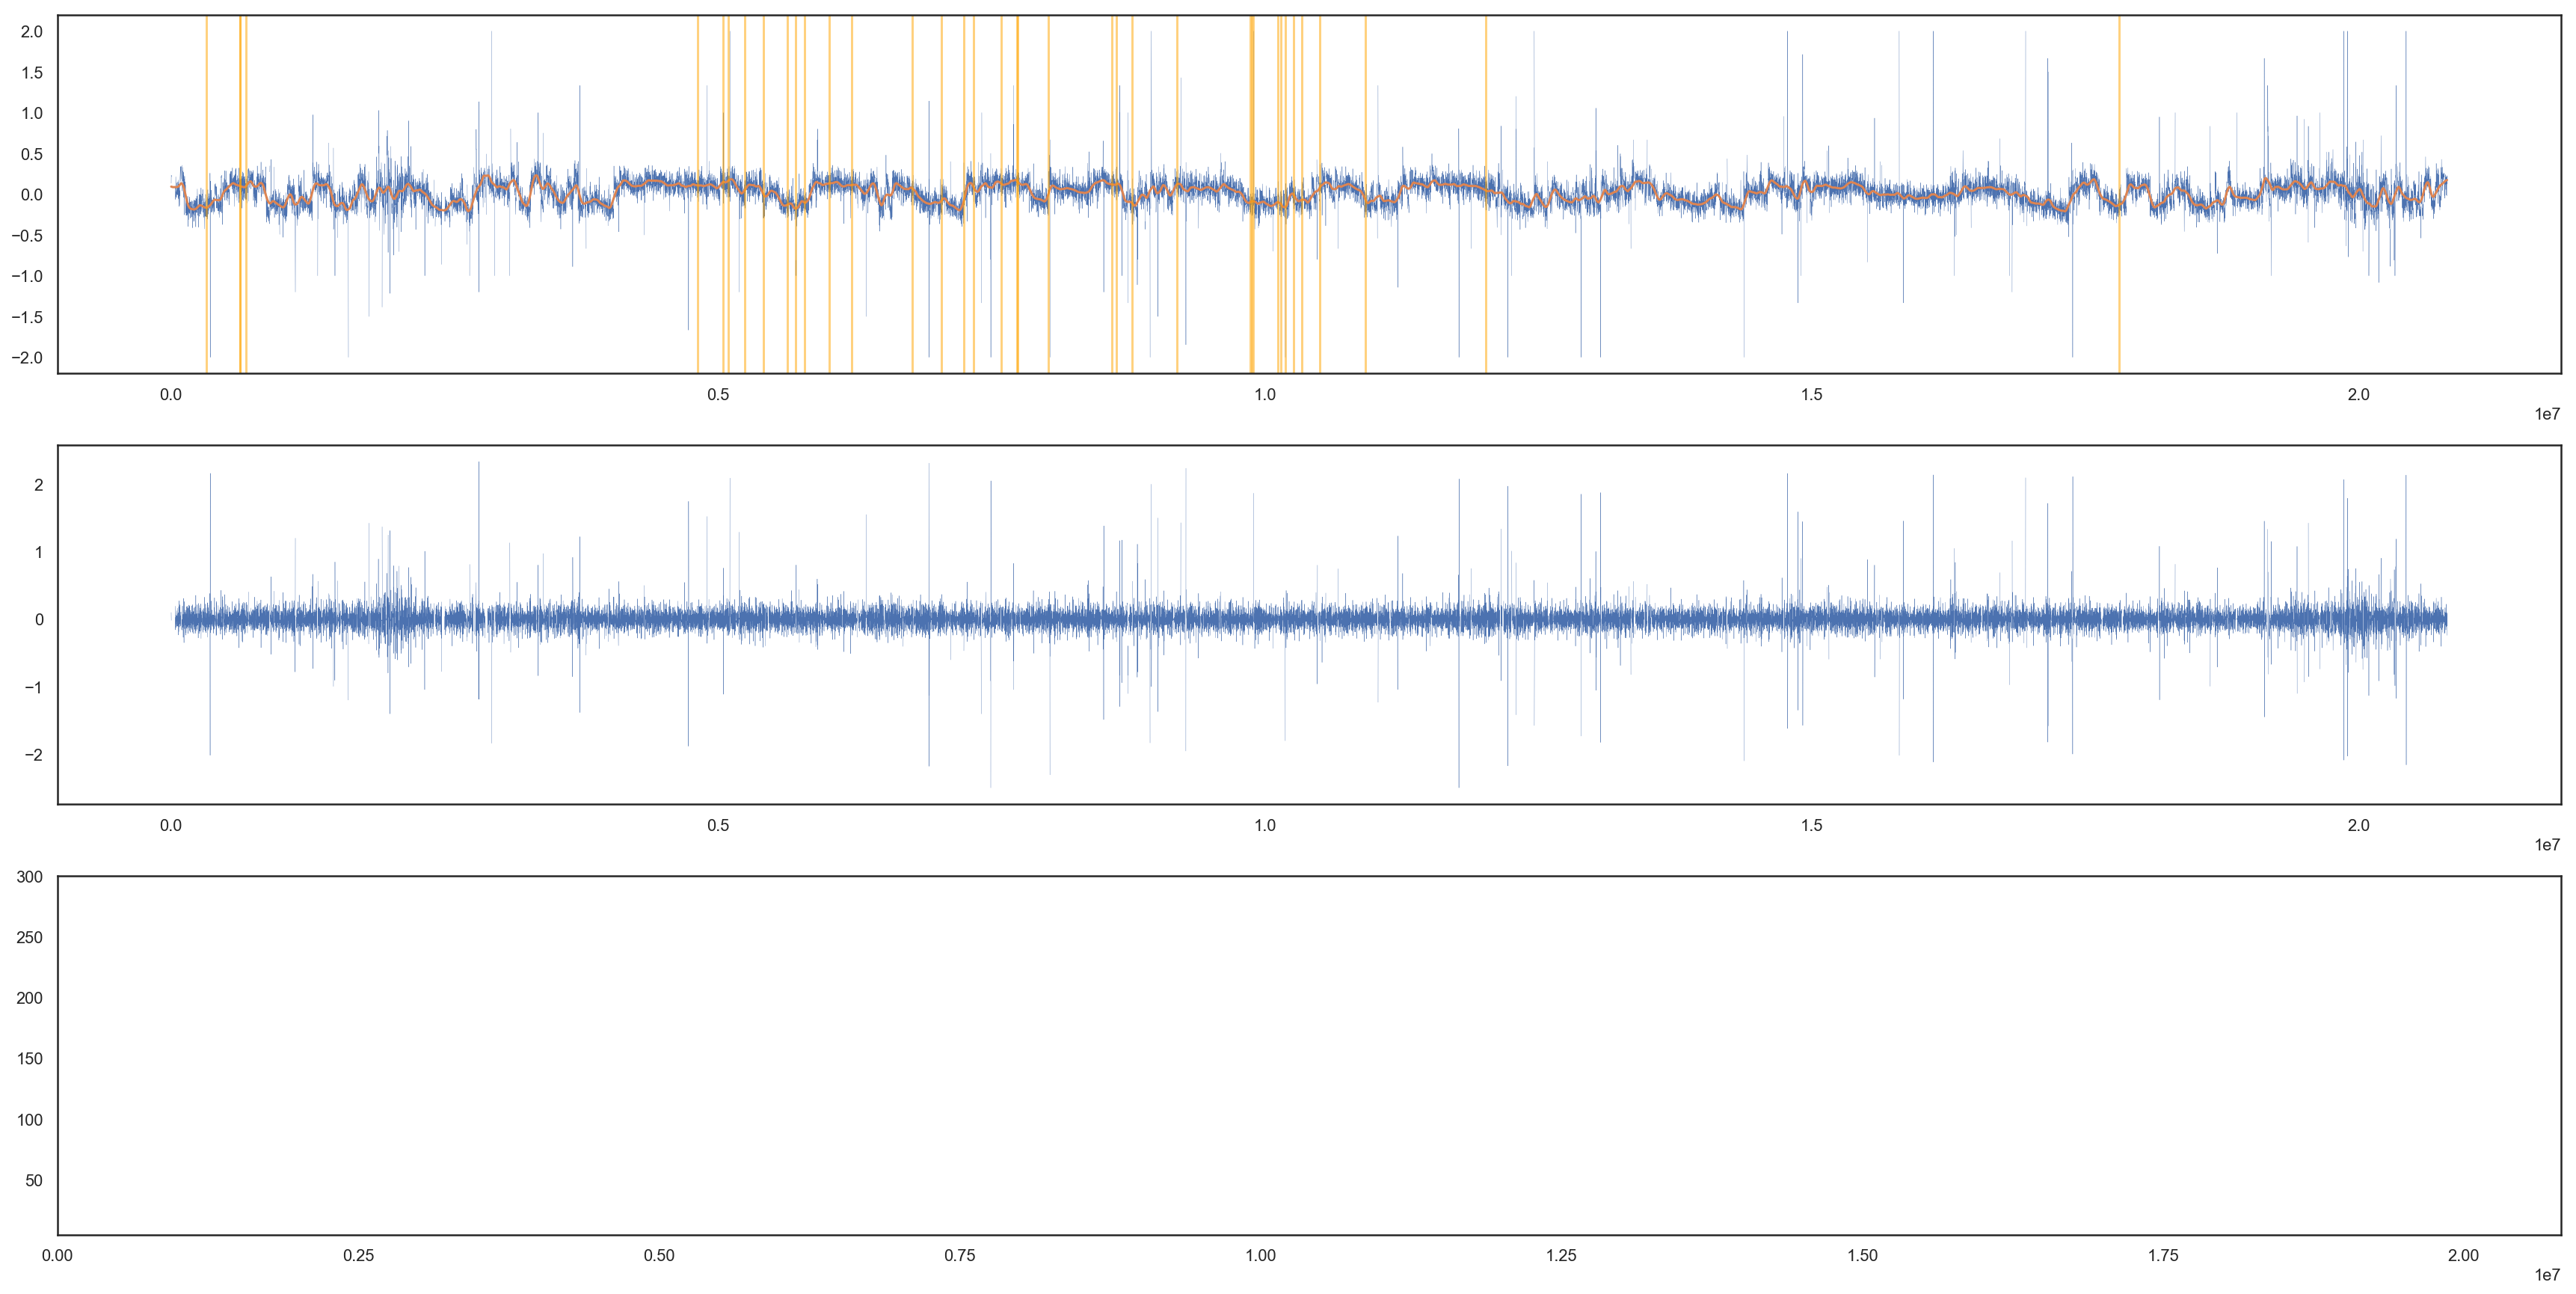

In [16]:
chrom='10'
origins = s_jumps(grouped.get_group(chrom, 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

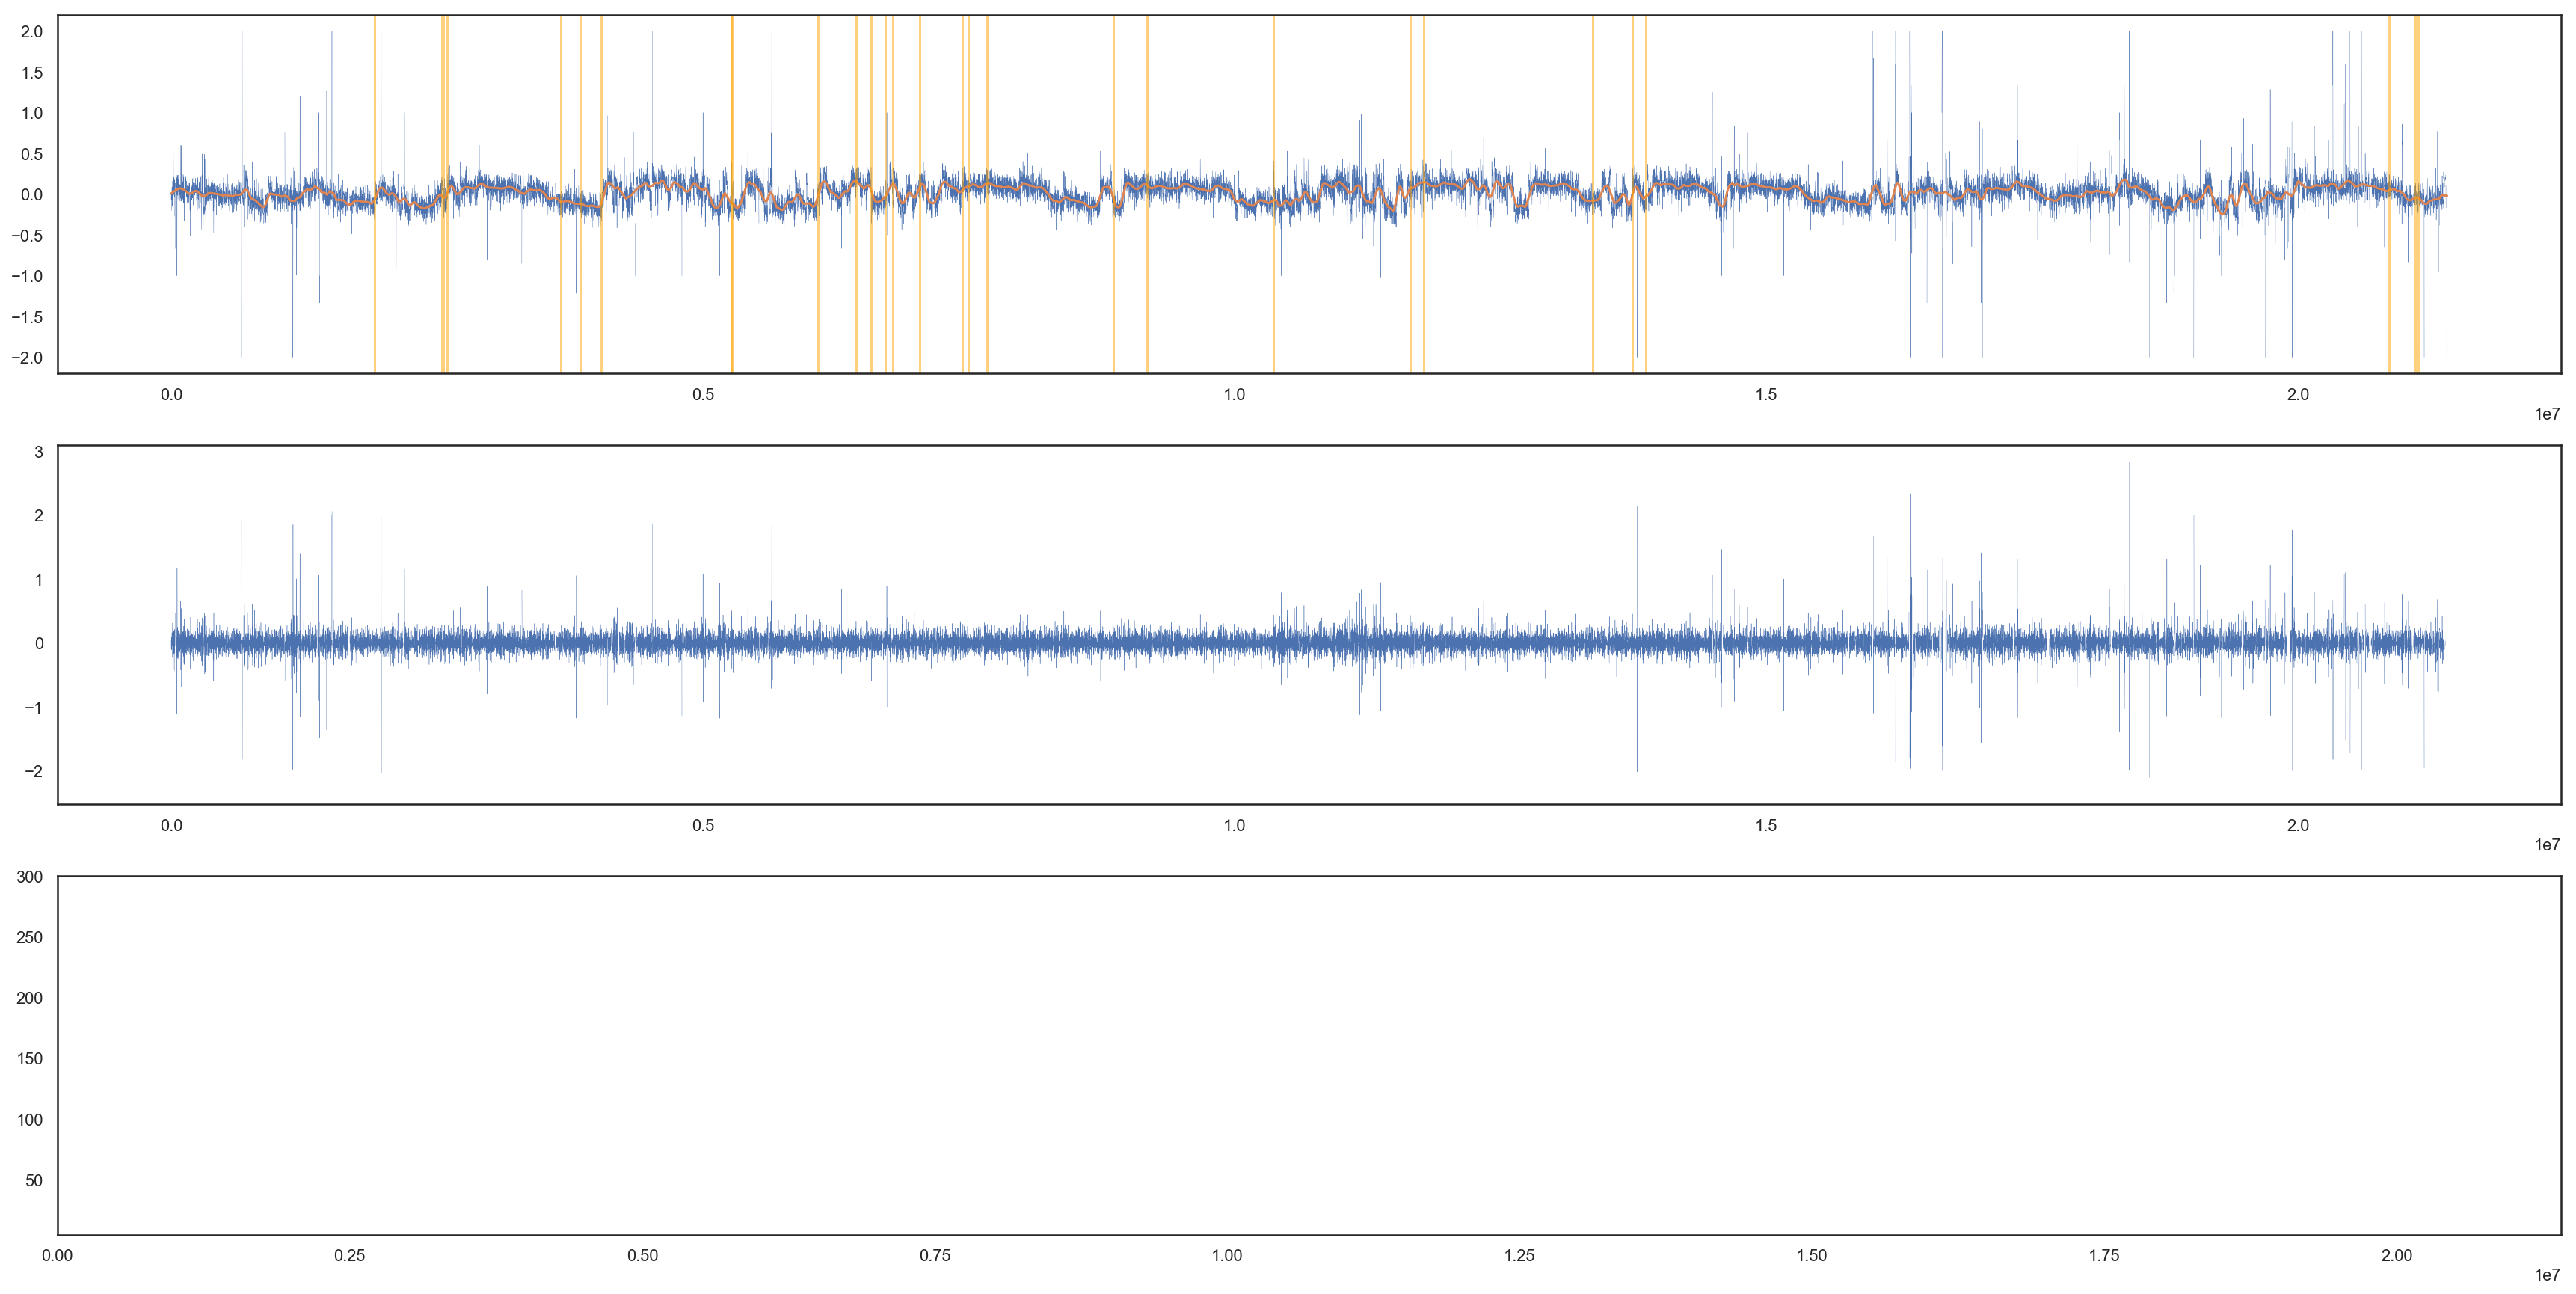

In [17]:
chrom='11'
origins = s_jumps(grouped.get_group(chrom), 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

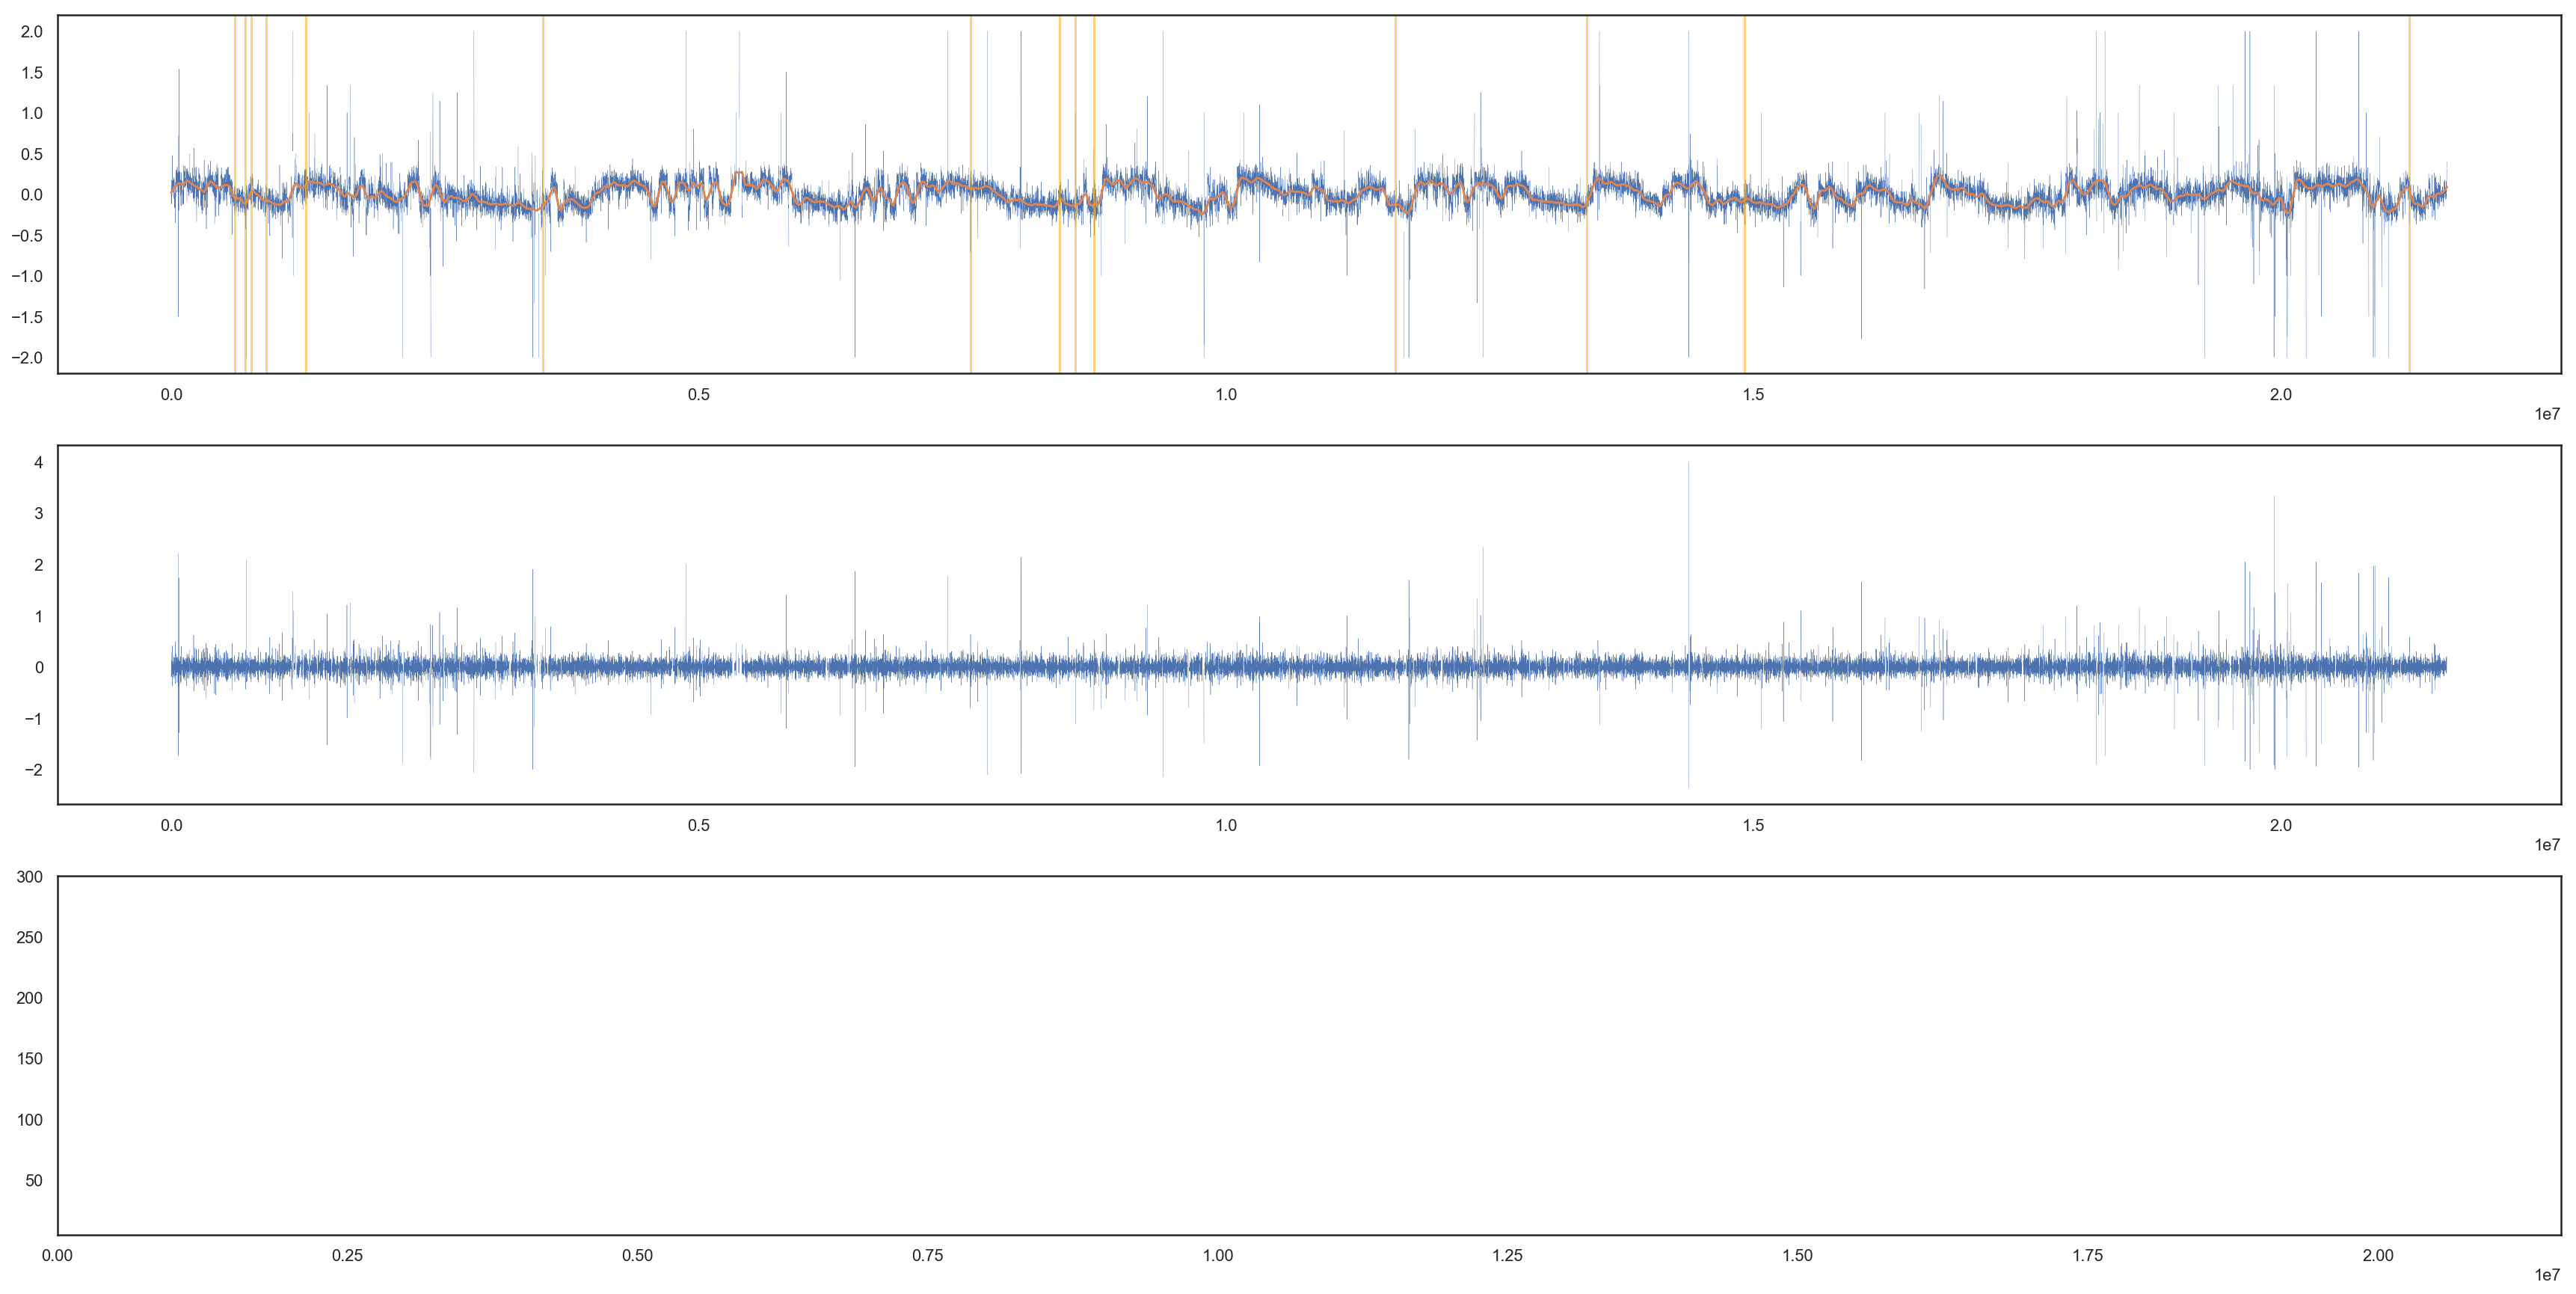

In [18]:
chrom='12'
origins = s_jumps(grouped.get_group(chrom), 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

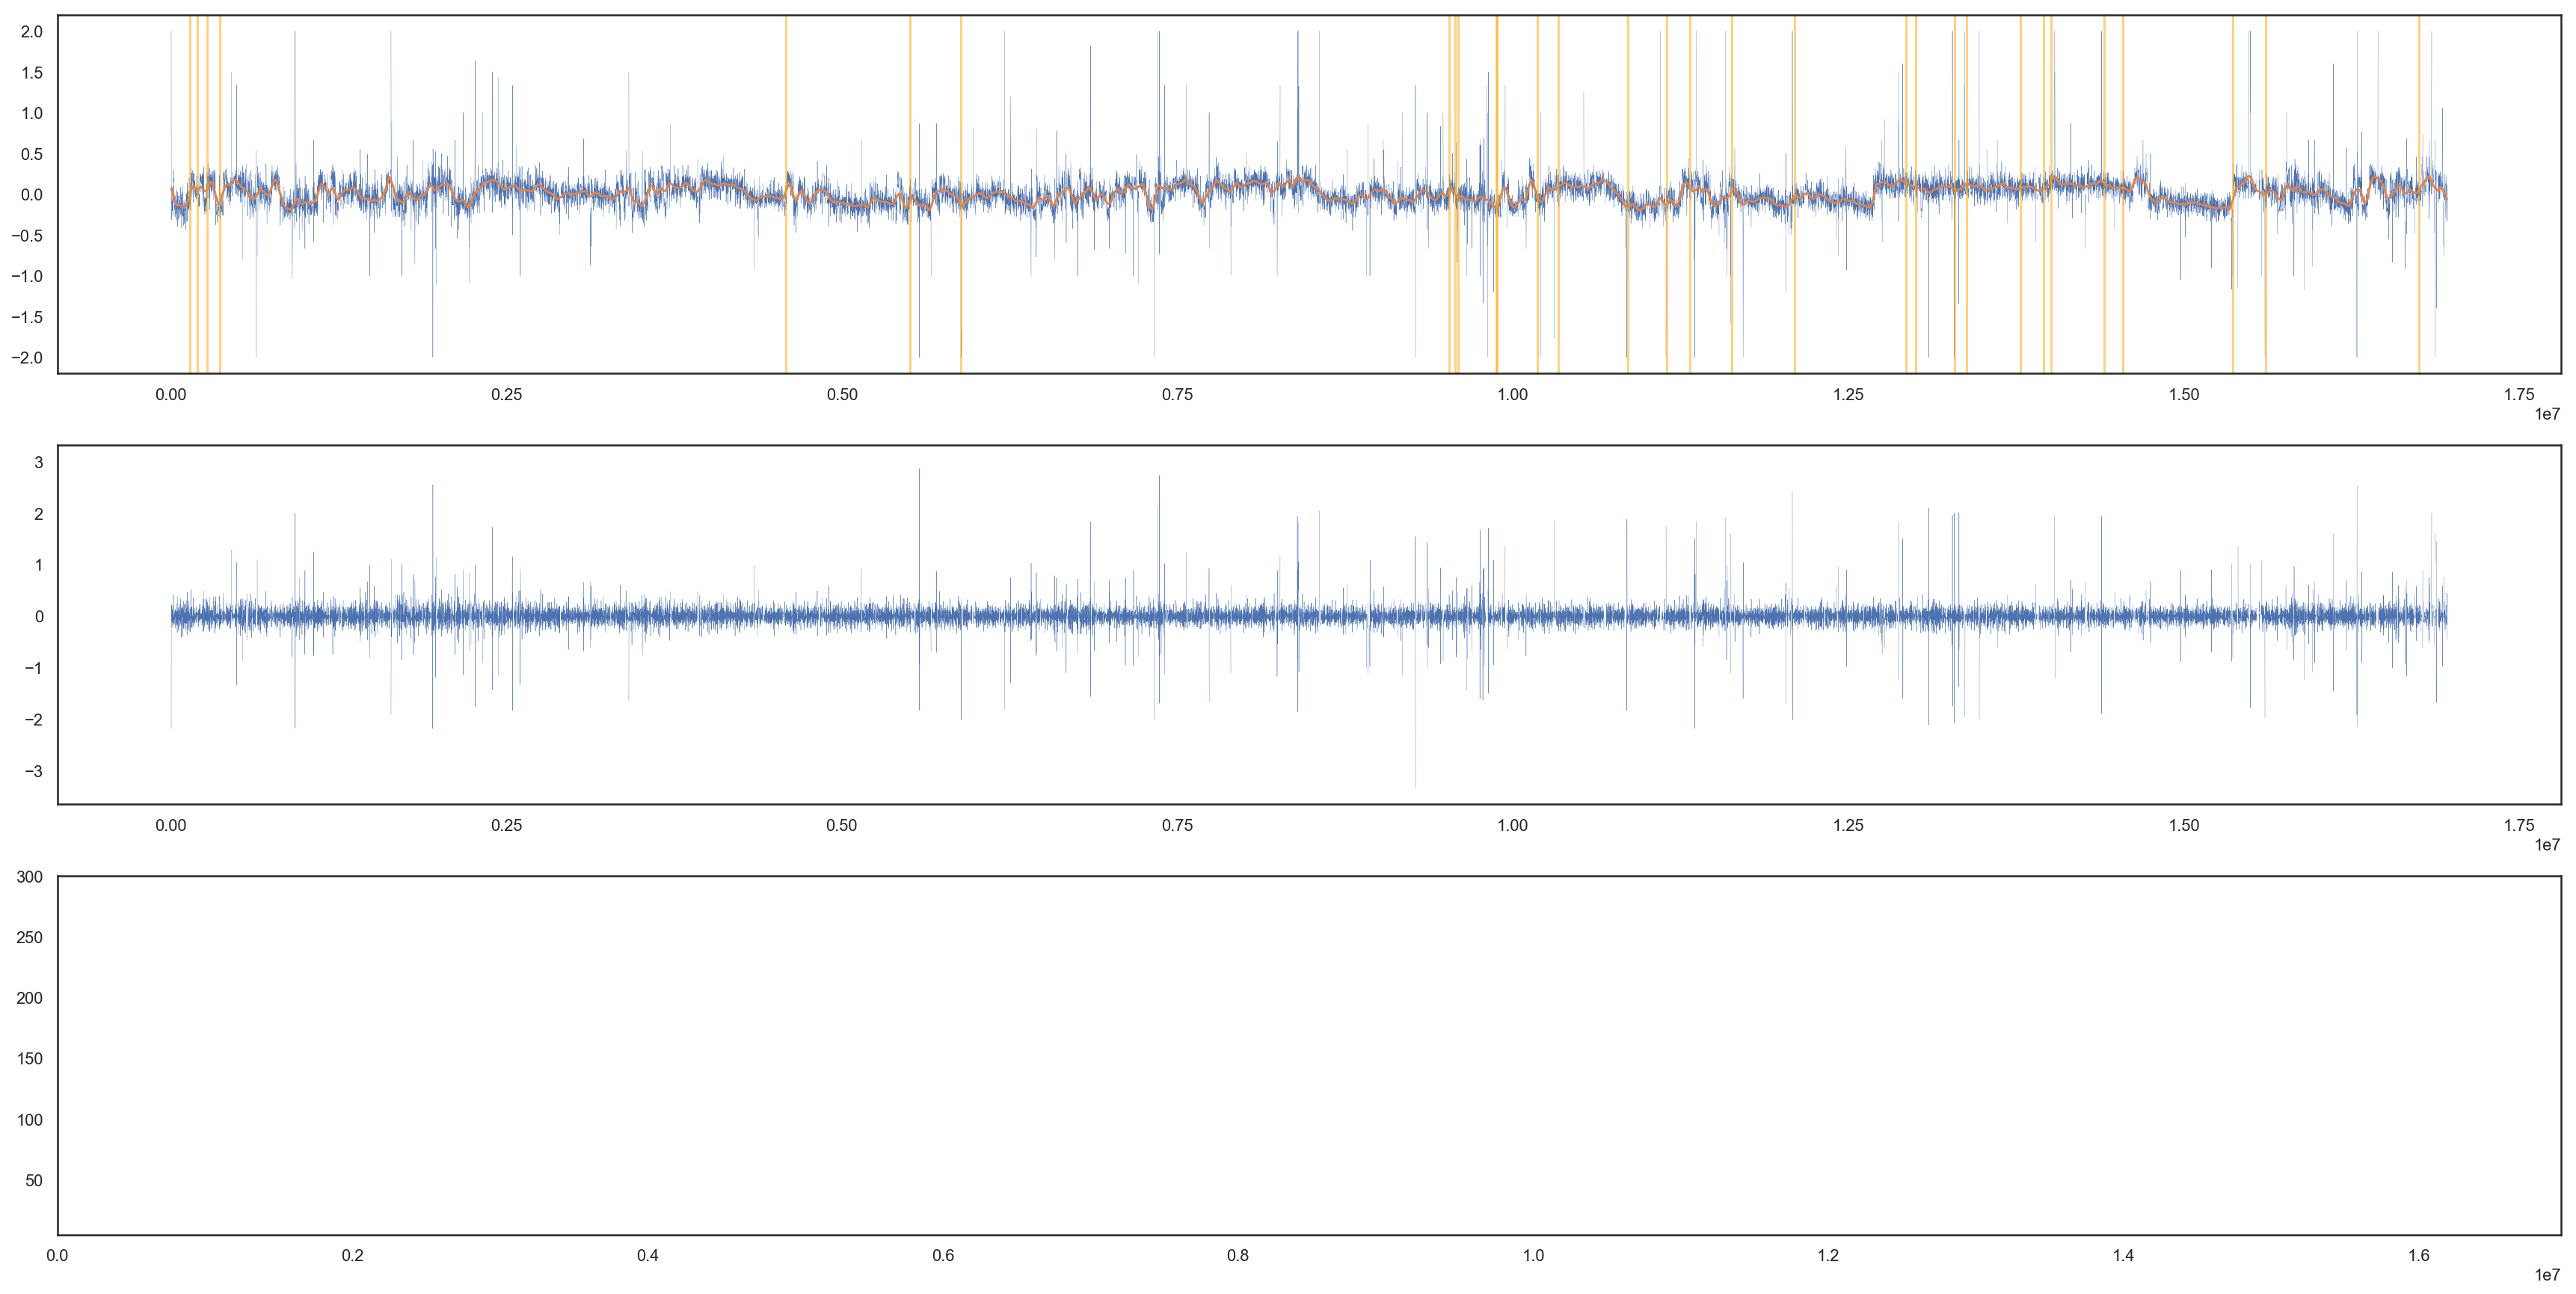

In [19]:
chrom='13'
origins = s_jumps(grouped.get_group(chrom), 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

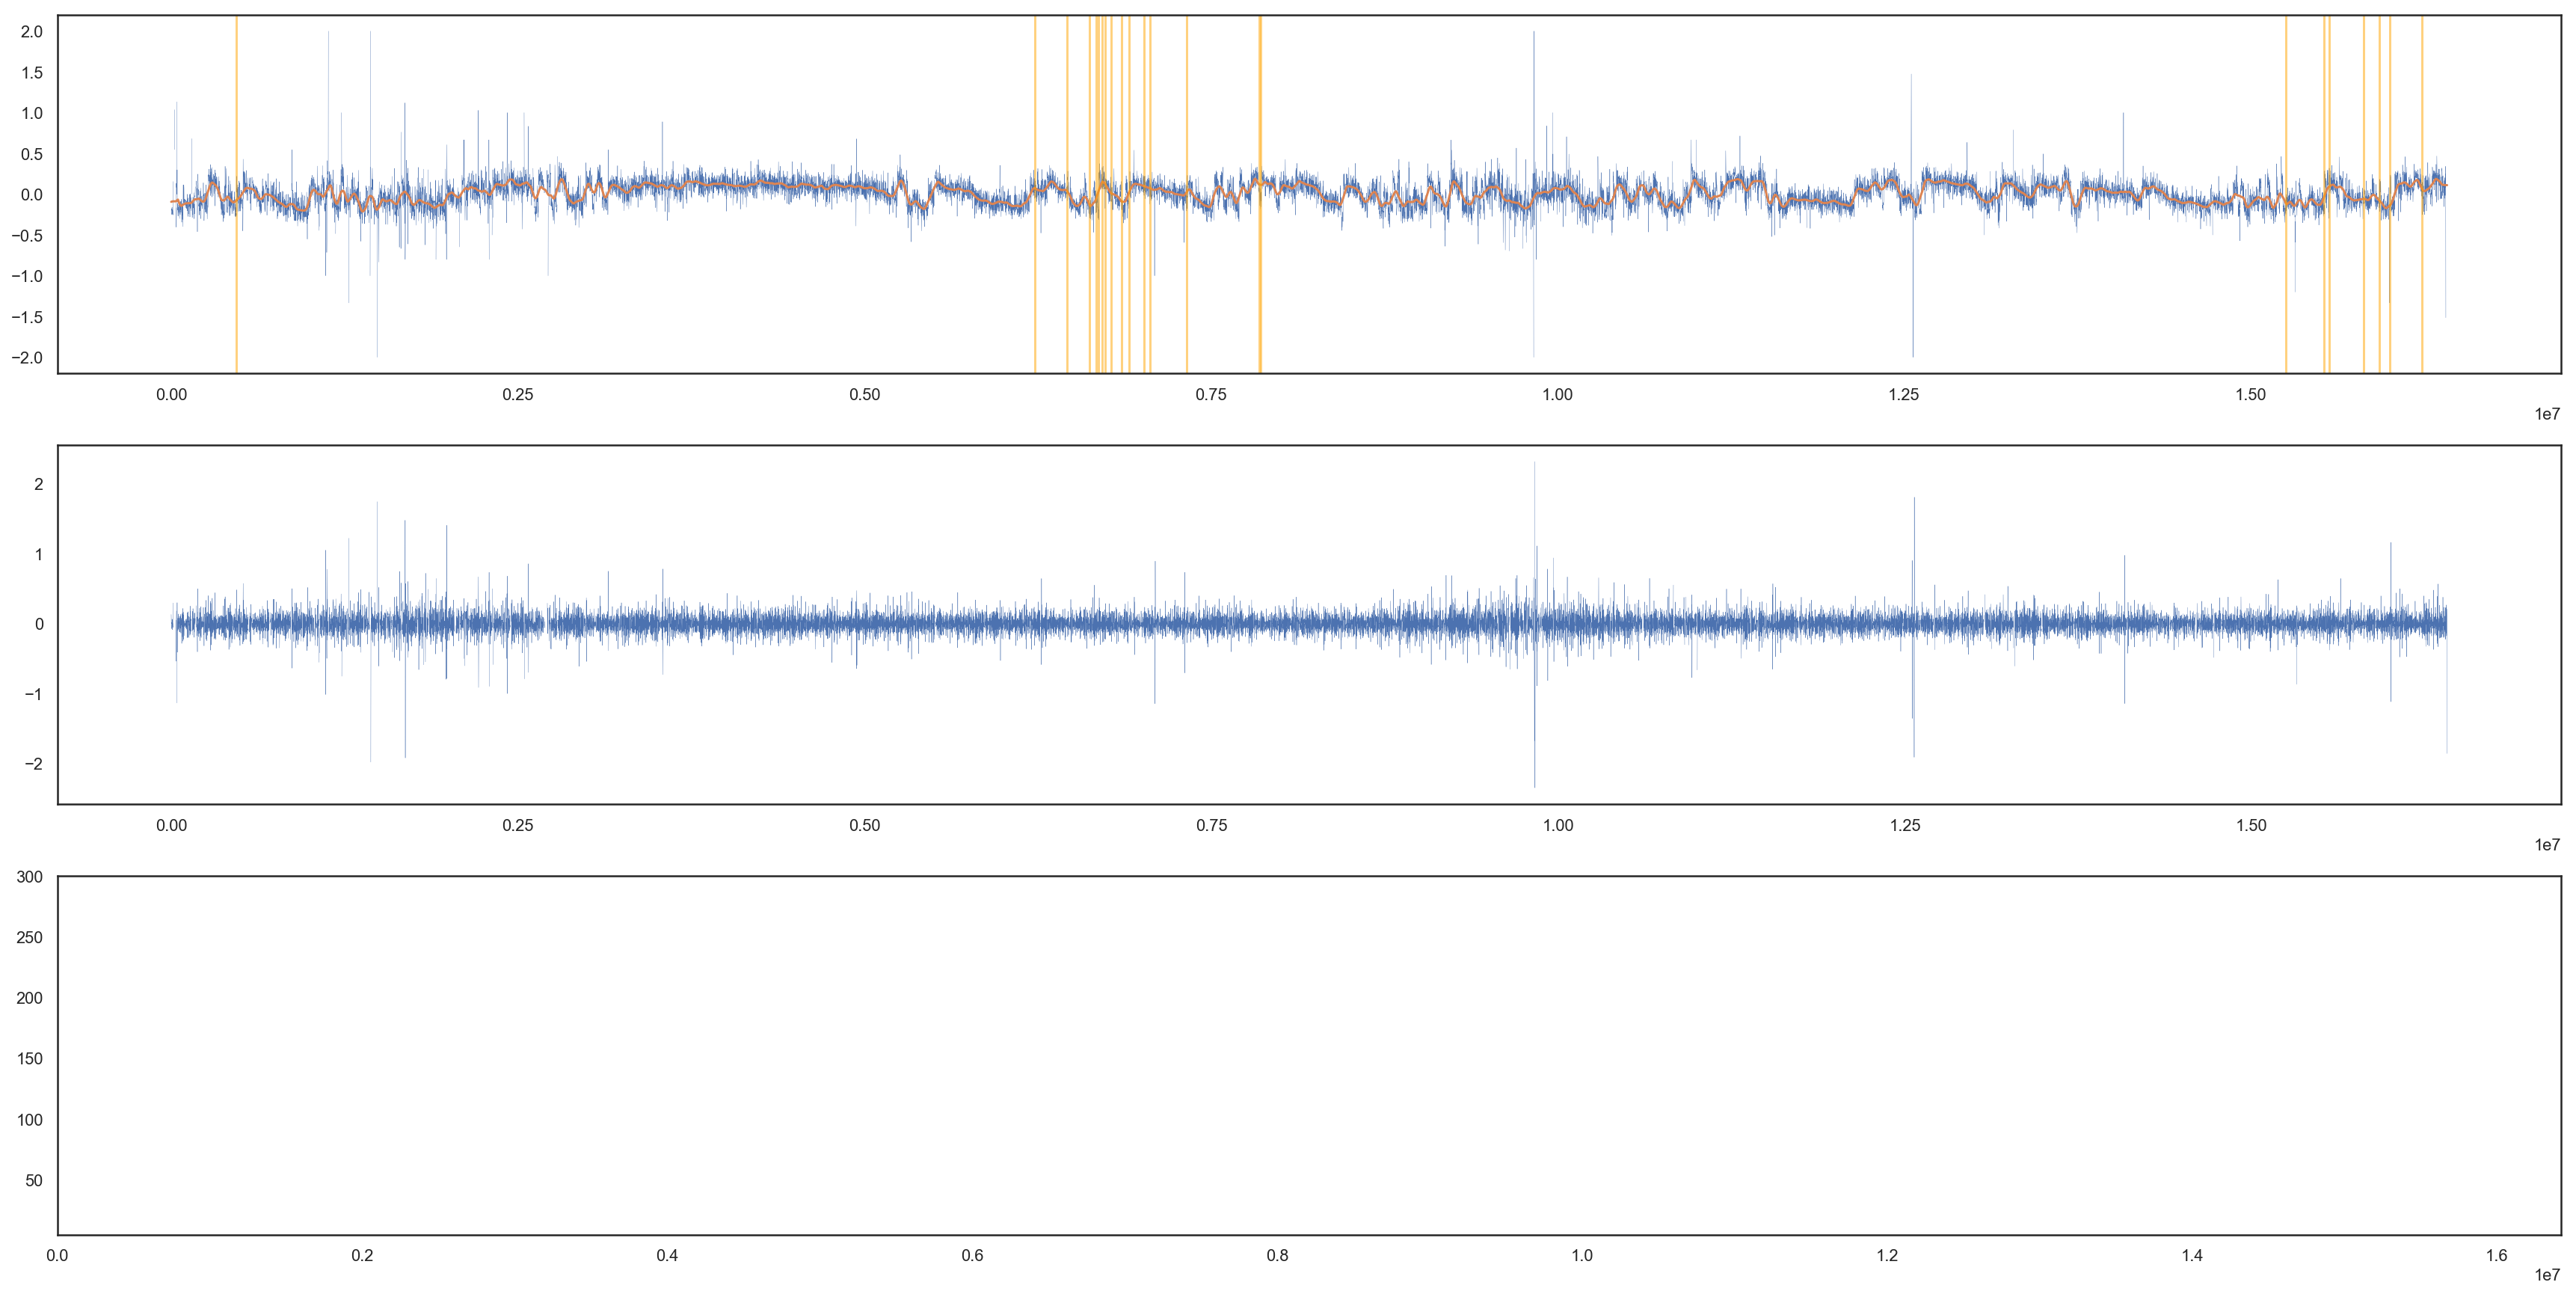

In [20]:
chrom='14'
origins = s_jumps(grouped.get_group(chrom), 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

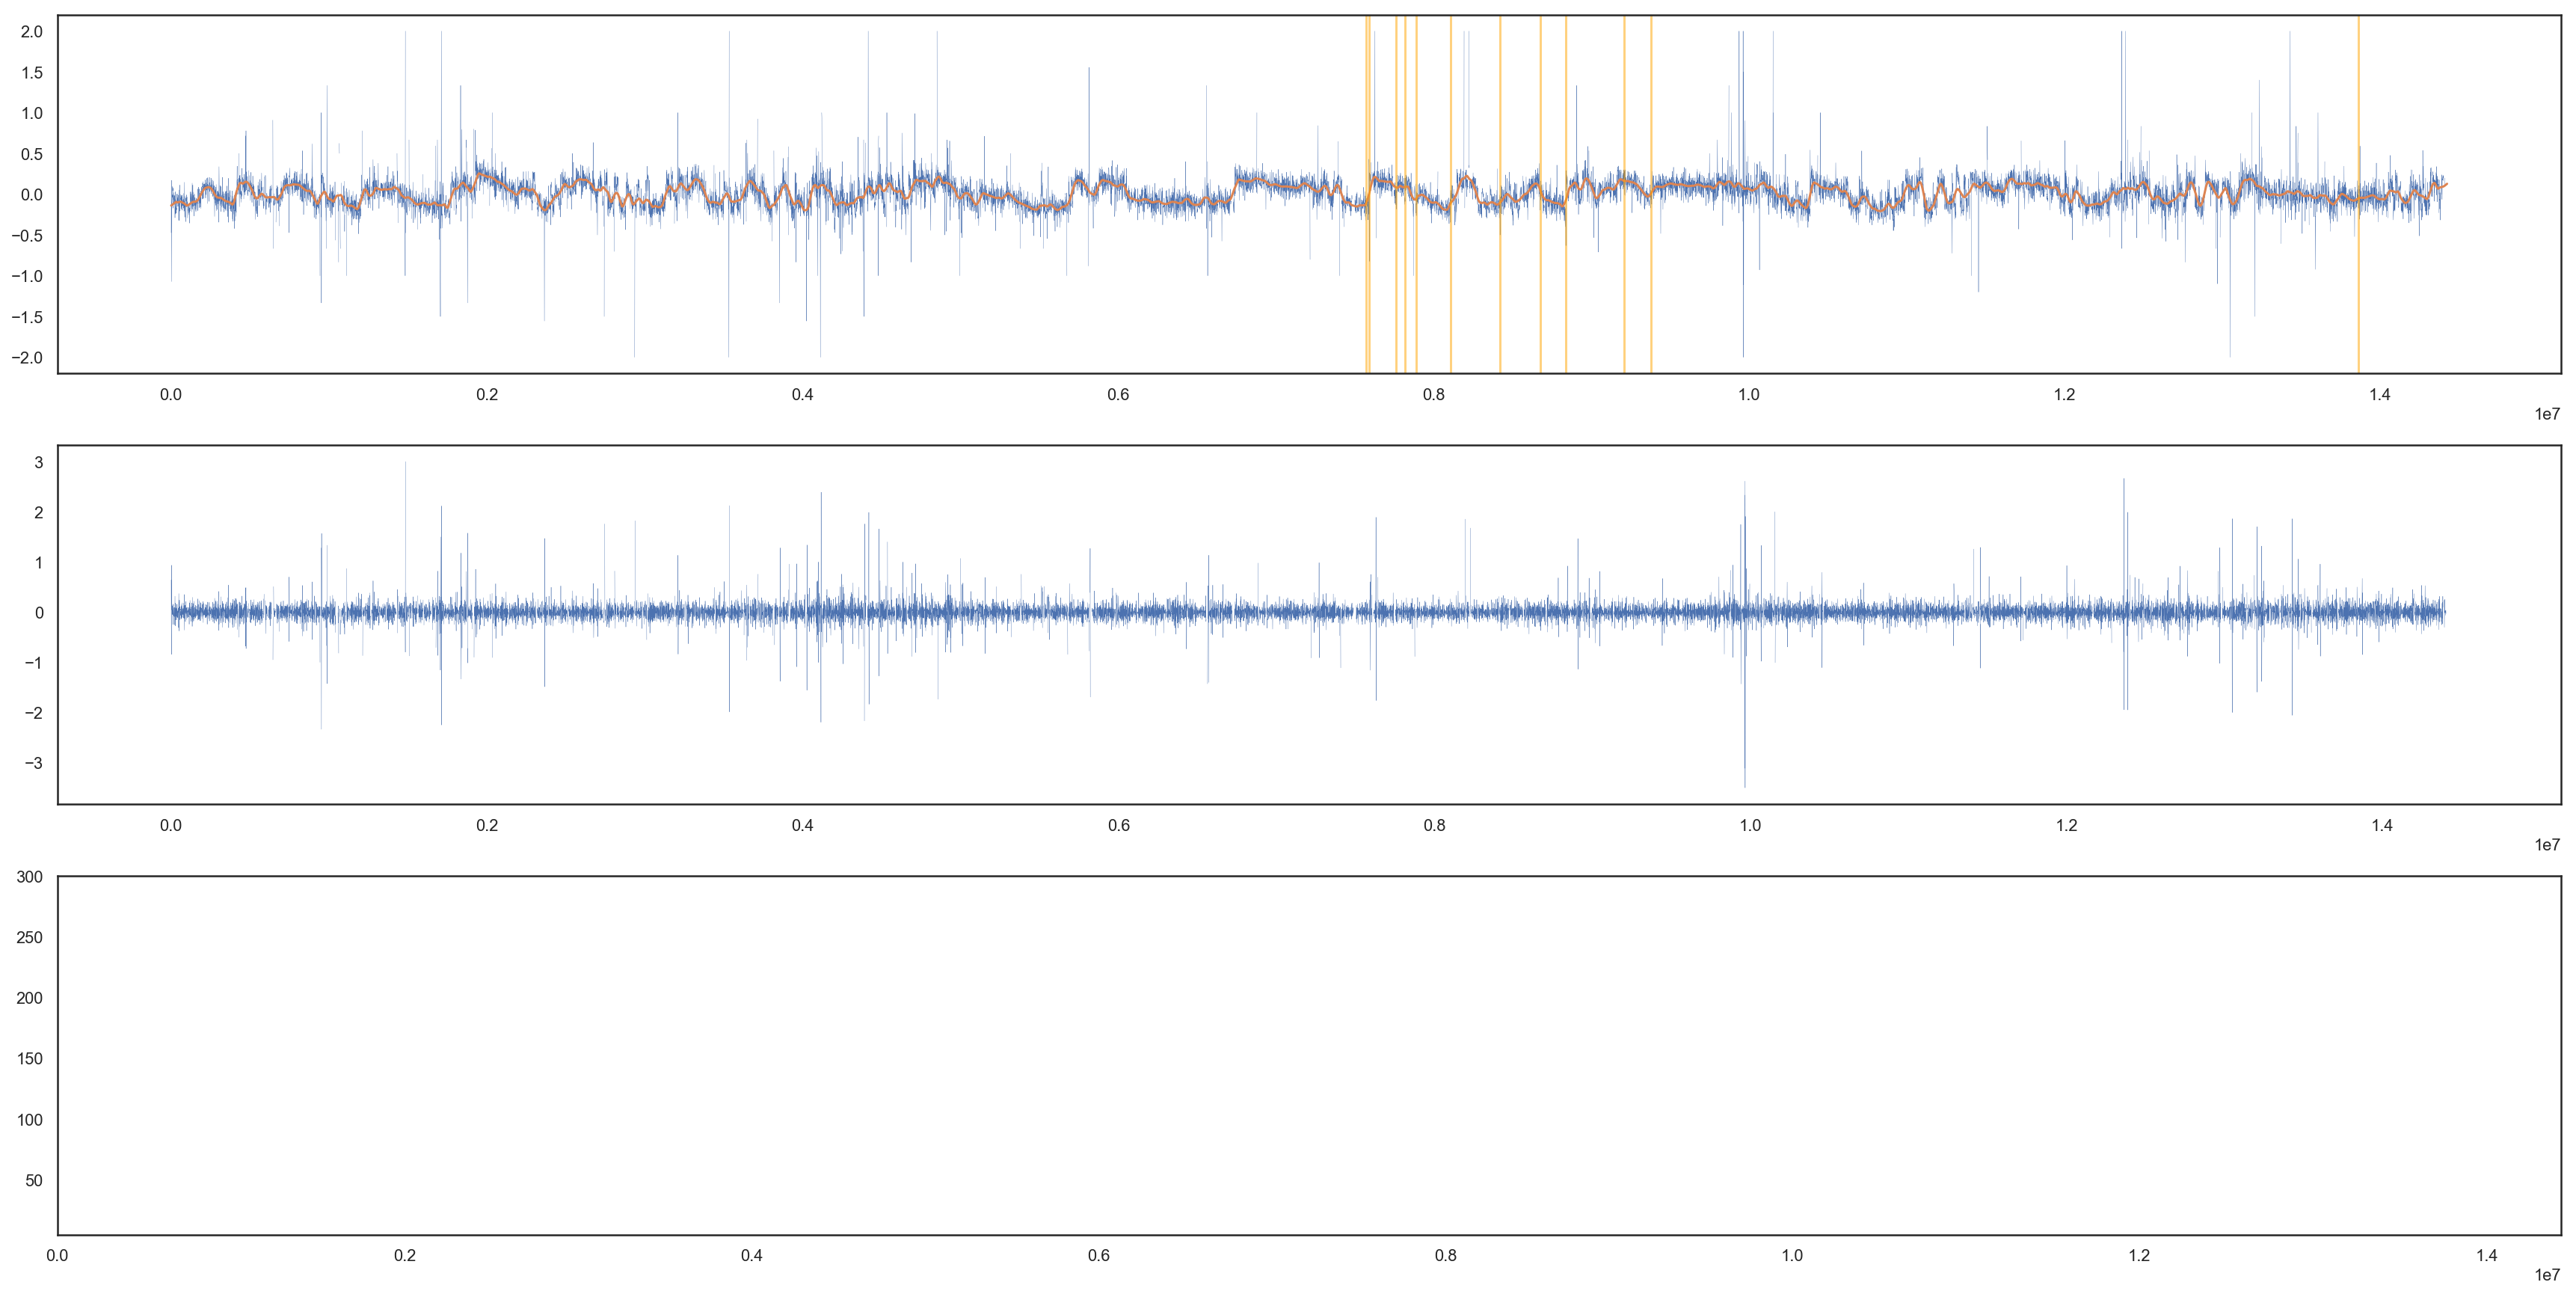

In [21]:
chrom='15'
origins = s_jumps(grouped.get_group(chrom), 's_diff', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

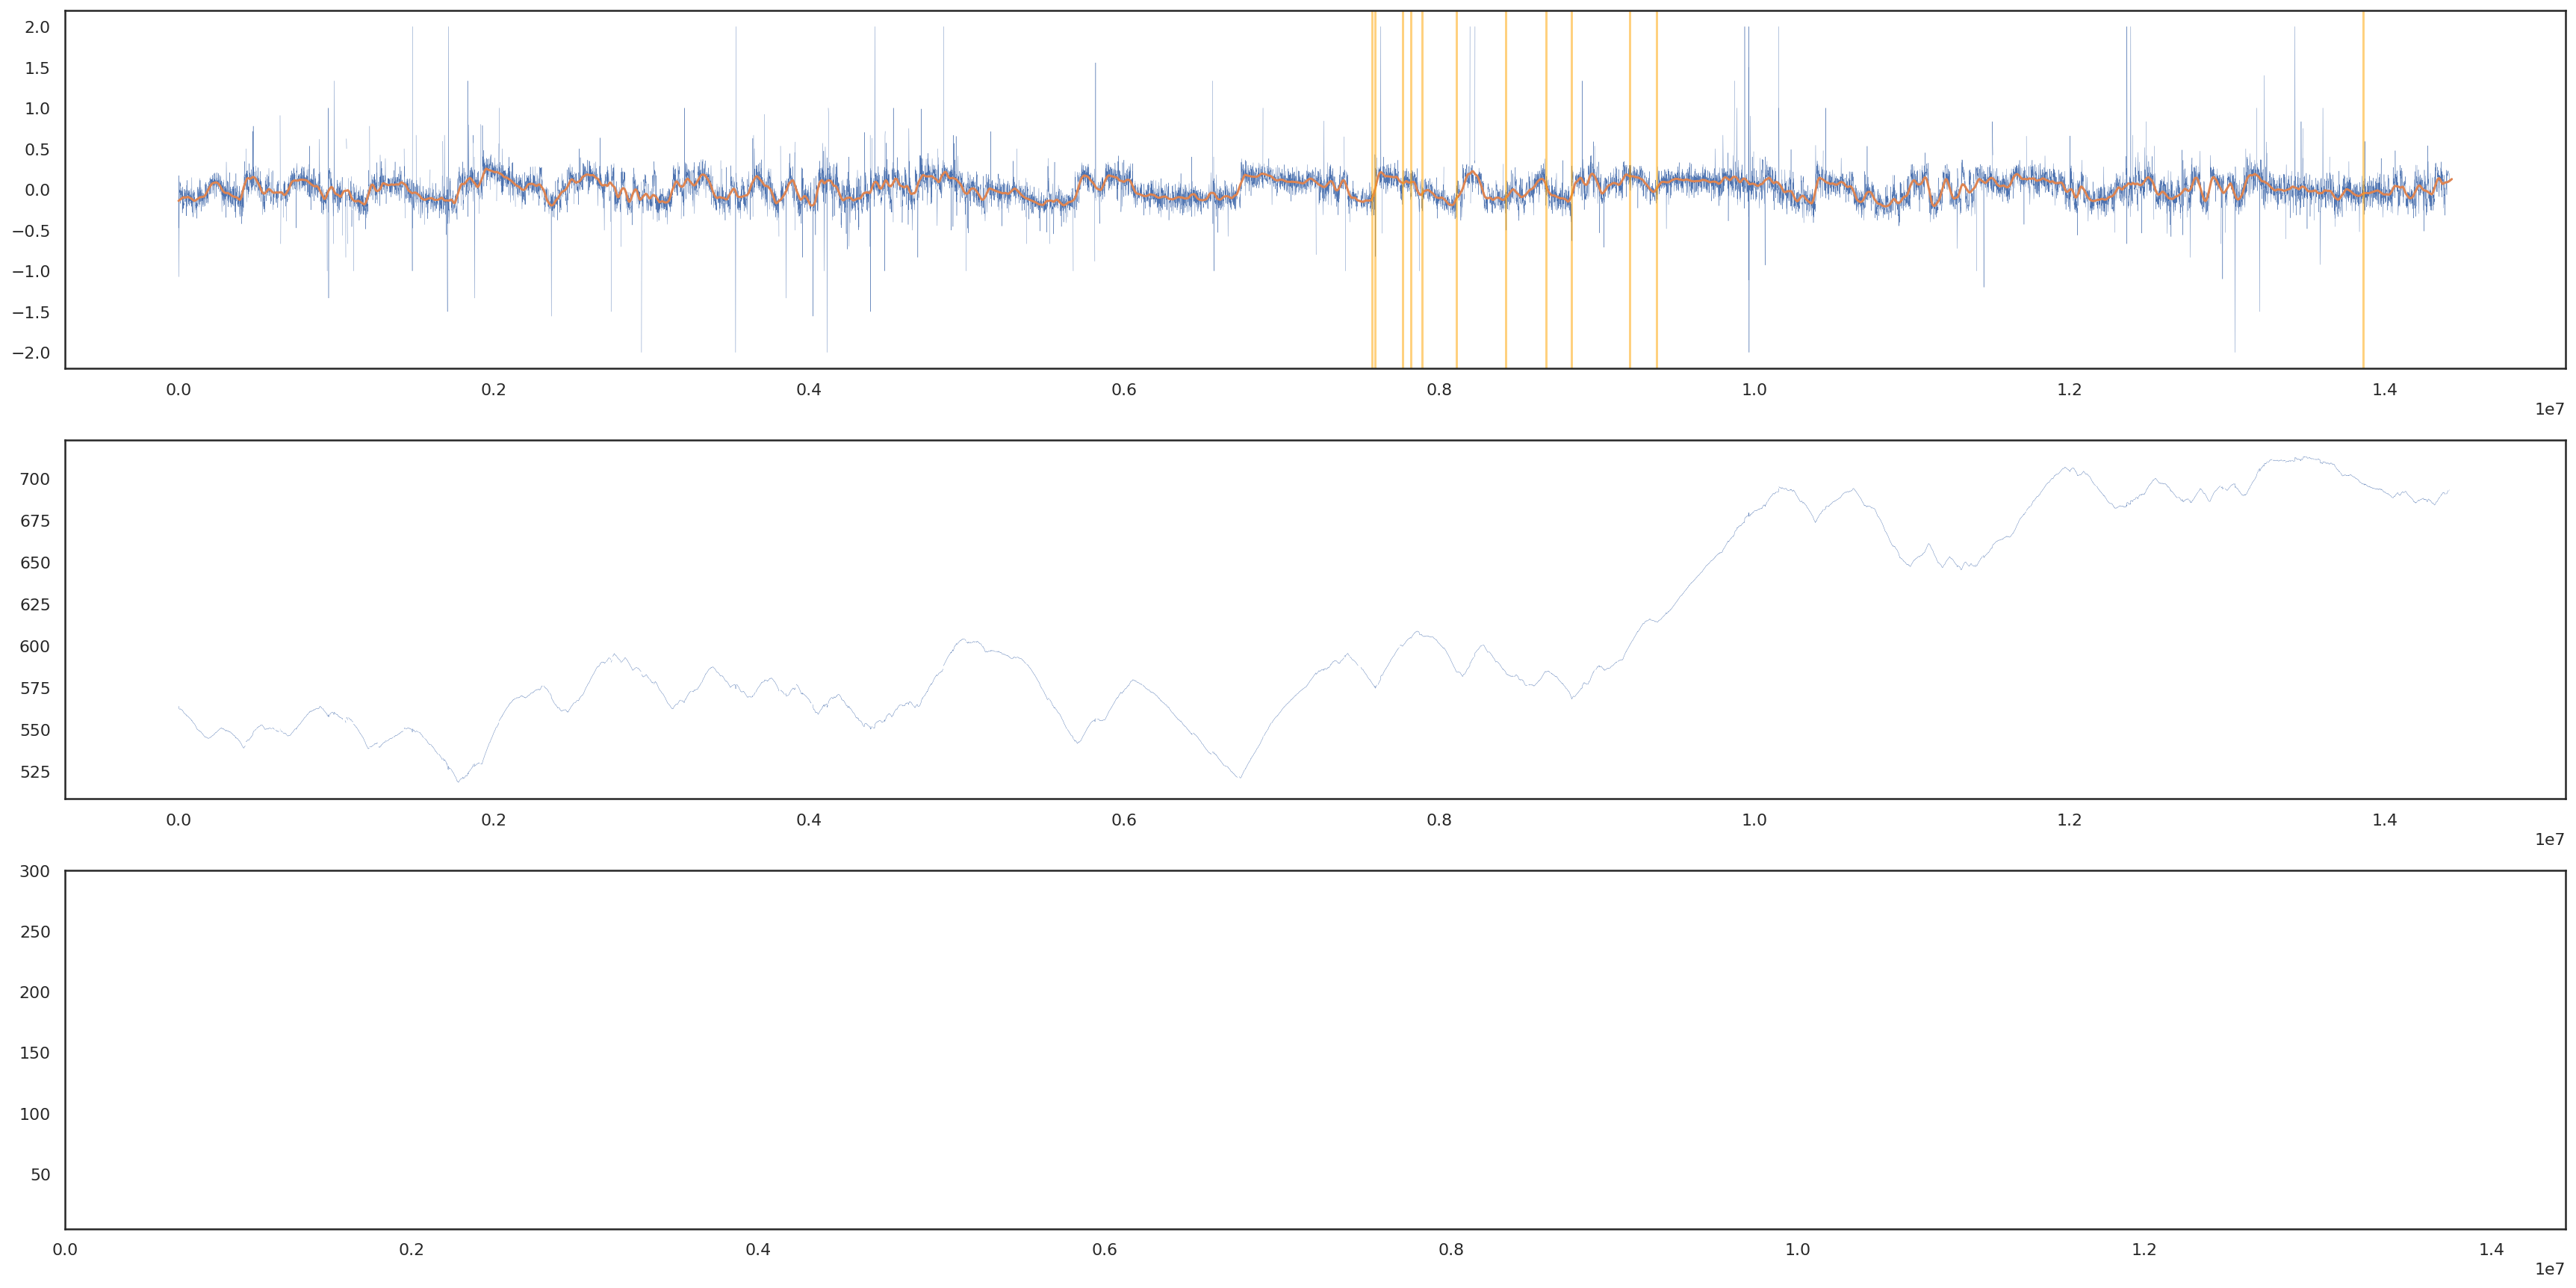

In [35]:
chrom='15'
origins = s_jumps(grouped.get_group(chrom), 's_cum', plot=True, vlines=hotspot_overlaps.loc[hotspot_overlaps.chrom == chrom].start)

## Write figs for all chromosomes

In [32]:
repl_orig_pos = dict()
for chrom in chromosomes:
    repl_orig_pos[chrom] = s_jumps(grouped.get_group(chrom), 's_diff', plot=False)

KeyboardInterrupt: 

## Find the replication orign closest to each hotspot:

In [22]:
def closest_repl_origin(hotspot_pos, repl_orig_pos):
    result = list()
    for x in hotspot_pos:
        i = np.argmin(np.absolute(x - repl_orig_pos))
        result.append(repl_orig_pos[i])
    return result
     
# make data frame with chrom, pos, and closest_origin to map back to hotspot_overlaps
gr_lst = list()
for chrom, gr in hotspot_overlaps.groupby('chrom', as_index=False):
    df = gr.loc[:, ['chrom', 'pos']]
    df['closest_orig'] = closest_repl_origin(df.pos, repl_orig_pos[chrom])
    gr_lst.append(df)
closest_orig = pd.concat(gr_lst).set_index(['chrom', 'pos'])

# set indexes and add new columns
hotspot_overlaps.set_index(['chrom', 'pos'], inplace=True)
hotspot_overlaps['closest_orig'] = closest_orig
hotspot_overlaps.reset_index(inplace=True)
# hotspot_overlaps['proximal_orig'] = (hotspot_overlaps.closest_orig - hotspot_overlaps.pos).abs() <= 5000
# hotspot_overlaps.proximal_orig.sum() / hotspot_overlaps.proximal_orig.size

hotspot_overlaps.to_hdf('hotspot_overlaps.pdf', 'df', format='table', mode='w')

ValueError: attempt to get argmin of an empty sequence

Plot distribution of distances between hotspots and their closest replication origin:

In [ ]:
with sns.axes_style('whitegrid'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.hist(hotspot_overlaps.closest_orig - hotspot_overlaps.pos, bins=50) ;
    ax1.axvline(0, color='orange')
    ax1.tick_params(axis='x', labelrotation=45)

    ax2.hist((hotspot_overlaps.closest_orig - hotspot_overlaps.pos).abs(), bins=50) ;
    ax2.tick_params(axis='x', labelrotation=45)

Closest distance between two uniformly distributed lists:

In [ ]:
a = np.random.randint(0, 1e10, size=10000)
b = np.random.randint(0, 1e10, size=10000)
c = np.array(closest_repl_origin(a, b))
plt.hist(np.absolute(a-c), bins=50) ;

I looks like the distributions are very similar, and any difference could be due to the non-random disttribution of hotspots from the Przeworski project.

## Remap skew data from centers of hotspots

In [ ]:
import genominterv

importlib.reload(genominterv) ;

In [ ]:
# test = genominterv.interval_distance(skew_data, hotspot_overlaps)
# test.head()

First get all windows that do not overlap hotspots:

In [ ]:
skew_data_dist = (genominterv.remap_interval_data(skew_data, 
                                                  hotspot_overlaps.assign(start=hotspot_overlaps.pos, end=hotspot_overlaps.pos)
                                                 )
                  # exclude windows between ends of chromosomes and a hotspot:
                  .loc[lambda df: ~df.prox_start.isnull() & ~df.prox_end.isnull()]
                 )
skew_data_dist.head()

Then get windows that overlaps hotspot centers:

In [ ]:
skew_data_grouped = skew_data.groupby('chrom')
hotspot_overlaps_grouped = hotspot_overlaps.groupby('chrom')

df_list = list()
for chrom in chromosomes:
    skew_group = skew_data_grouped.get_group(chrom)
    hotspot_group = hotspot_overlaps_grouped.get_group(chrom)

    skew_starts = skew_group.start.tolist()
    skew_ends = skew_group.end.tolist()

    idx_list = list()    
    for pos in hotspot_group.pos:
        idx = bisect.bisect_right(skew_starts, pos) - 1
        if pos < skew_ends[idx]:
            idx_list.append(idx)
        else:
            assert 0, (pos, skew_starts[idx], skew_ends[idx])
        idx_list = sorted(set(idx_list))
    df_list.append(skew_group.iloc[idx_list])

skew_data_overlap = pd.concat(df_list).reset_index(drop=True)
skew_data_overlap.head()

Add the extra columns that are in `skew_data_dist` so concatention is possible and set `start` and `end` to 0:

In [ ]:
skew_data_overlap['prox_start'] = skew_data_overlap.start
skew_data_overlap['prox_end'] = skew_data_overlap.end

skew_data_overlap['start_orig'] = skew_data_overlap.start
skew_data_overlap['end_orig'] = skew_data_overlap.end
skew_data_overlap['start'] = 0
skew_data_overlap['end'] = 0
skew_data_overlap.head()

Concatenate data frames and add `pos` and `bin` columns:

In [ ]:
skew_data_hotspot_centered = pd.concat([skew_data_overlap, skew_data_dist], sort=True)
skew_data_hotspot_centered['pos'] = skew_data_hotspot_centered.start + \
    (skew_data_hotspot_centered.end - skew_data_hotspot_centered.start) / 2
skew_data_hotspot_centered['bin'] = skew_data_hotspot_centered.pos // 1000 * 1000
skew_data_hotspot_centered.head()

Distribution of distances of windows to hotspots:

In [ ]:
plt.hist(skew_data_hotspot_centered.start, bins=100) ;

## Merge hotspot data onto hotspot centered skew data

In [ ]:
hotspot_skew_data = skew_data_hotspot_centered.merge(hotspot_overlaps
                                     .assign(start=hotspot_overlaps.pos, end=hotspot_overlaps.pos),
                                 how='left', 
                                 left_on=['chrom', 'prox_start', 'prox_end'],
                                 right_on=['chrom', 'start', 'end'],
                                 suffixes=['', '_hotspot']
                                )
hotspot_skew_data.head()

In [ ]:
plot_df = (hotspot_skew_data
           .loc[hotspot_skew_data.bin.abs() < 50000]
           .assign(s_subst = lambda df: (df.skew_XGXC - df.skew_XGXC.shift()) + (df.skew_XTXA - df.skew_XTXA.shift()))
          )



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

with sns.axes_style('whitegrid'):
    with sns.color_palette('colorblind'):
        sns.lineplot('bin', 's', data=plot_df, ax=ax1, markers=True)
        sns.lineplot('bin', 's_subst', data=plot_df, ax=ax2, markers=True)
        ax2.set_ylim(-0.04, 0.04)
#         ax1.axvline(0)
#         ax1.axhline(0)
#         ax1.axvline(-500, linestyle='dashed')
#         ax1.axhline(0, linestyle='dashed') ;

In [ ]:
plot_df = (hotspot_skew_data[['bin', 's', 'exons', 'introns', 'promoters_minus', 'promoters_plus', 'intergenic']]
           .loc[hotspot_skew_data.bin.abs() < 50000]
           .melt(id_vars=['bin', 's'])
          )
with sns.axes_style('whitegrid'):
    with sns.color_palette(['grey', sns.color_palette('colorblind')[0]]):
        g = sns.FacetGrid(plot_df, col='variable', hue='value', height=6, aspect=0.5)
        g = g.map(sns.lineplot, 'bin', 's').add_legend()

new_labels = {'0.0': 'No', '1.0': 'Yes'}
for t in g._legend.texts:
    t.set_text(new_labels[t.get_text()])
g._legend.set_title('Overlaps')

In [ ]:
hotspot_overlaps.promoters_plus.sum() + hotspot_overlaps.promoters_minus.sum(), len(hotspot_overlaps)

How many propmoters are there compared to repication origins?

In [ ]:
print('predicted origins:', sum(len(x) for x in repl_orig_pos.values()))
print('hotspots:', len(hotspot_overlaps))

The zebra finch genome size is 1.23 Gb. So if replication orgins are spaced about 1-2 Mb appart we expect about 600-1200 orgins.

Considering that there are 17-18,000 coding genes, only about 4-7% or promoters can overlap origins - even if origins only fall in promoters.





## Center skew data around predicted origins

In [ ]:
records = list()
for k, v in repl_orig_pos.items():
    for p in v:
        records.append((k, p))

pd.DataFrame().from_records(records, columns=['chrom', 'start']).assign(end=lambda df: df.start)


## Center skew data around promoters

## Center skew data around CpG islands

## Center skew data around TSSs

## Group hotspots by distance form an origin

In [ ]:
bins = hotspot_skew_data.closest_orig // 100000 * 100000
grouped = hotspot_skew_data.groupby(bins)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, x in enumerate(range(0, 300000, 100000)):
    df = grouped.get_group(x)
    print(len(df.prox_start.unique()))
    sns.lineplot('bin', 's', data=df.loc[df.bin.abs() < 50000], ax=axes[i])